In [243]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [151]:
# removes whitespace from all the entries

dataDirectory = "../Data/GDP per hour worked.csv"
rawData = pd.read_csv(dataDirectory, header=0, nrows=None)
print(rawData.shape)
print(rawData.iloc[0])

(3894, 8)
LOCATION            AUS
INDICATOR      GDPHRWKD
SUBJECT             TOT
MEASURE             USD
FREQUENCY             A
TIME               1970
Value         26.841414
Flag Codes          NaN
Name: 0, dtype: object


In [126]:
print(rawData)

     LOCATION INDICATOR SUBJECT  MEASURE FREQUENCY  TIME       Value  \
0         AUS  GDPHRWKD     TOT      USD         A  1970   26.841414   
1         AUS  GDPHRWKD     TOT      USD         A  1971   27.511706   
2         AUS  GDPHRWKD     TOT      USD         A  1972   28.118733   
3         AUS  GDPHRWKD     TOT      USD         A  1973   28.699050   
4         AUS  GDPHRWKD     TOT      USD         A  1974   28.238426   
...       ...       ...     ...      ...       ...   ...         ...   
3889      COL  GDPHRWKD     TOT  IDX2015         A  2017  102.999044   
3890      COL  GDPHRWKD     TOT  IDX2015         A  2018  104.503819   
3891      COL  GDPHRWKD     TOT  IDX2015         A  2019  107.793852   
3892      COL  GDPHRWKD     TOT  IDX2015         A  2020  129.049763   
3893      COL  GDPHRWKD     TOT  IDX2015         A  2021  114.789790   

     Flag Codes  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
3889     

In [127]:
dataWithAbsoluteValues = rawData.copy()
dataWithIndexValues = rawData.copy()

for row in range(rawData.shape[0]):
    if "USD" in rawData.iloc[row]['MEASURE']:
        dataWithIndexValues.drop(row, axis=0, inplace=True)
    else:
        dataWithAbsoluteValues.drop(row, axis=0, inplace=True)

dataWithAbsoluteValues.reset_index(inplace=True, drop=True)
dataWithIndexValues.reset_index(inplace=True, drop=True)

"""print(cleanedDataProductivityPerHourWorked.shape)
print(cleanedDataProductivityPerPerson.shape)"""

'print(cleanedDataProductivityPerHourWorked.shape)\nprint(cleanedDataProductivityPerPerson.shape)'

In [128]:
print(rawData['LOCATION'].unique())
print(rawData['LOCATION'].unique().shape)

['AUS' 'AUT' 'BEL' 'CAN' 'CZE' 'DNK' 'FIN' 'FRA' 'DEU' 'GRC' 'HUN' 'ISL'
 'IRL' 'ITA' 'JPN' 'KOR' 'LUX' 'MEX' 'NLD' 'NZL' 'NOR' 'POL' 'PRT' 'SVK'
 'ESP' 'SWE' 'CHE' 'TUR' 'GBR' 'USA' 'CHL' 'EST' 'ISR' 'RUS' 'SVN' 'OECD'
 'EU28' 'G-7' 'LVA' 'LTU' 'EA19' 'ZAF' 'CRI' 'BGR' 'HRV' 'ROU' 'EU27_2020'
 'COL']
(48,)


In [129]:
print(dataWithAbsoluteValues)

     LOCATION INDICATOR SUBJECT MEASURE FREQUENCY  TIME      Value Flag Codes
0         AUS  GDPHRWKD     TOT     USD         A  1970  26.841414        NaN
1         AUS  GDPHRWKD     TOT     USD         A  1971  27.511706        NaN
2         AUS  GDPHRWKD     TOT     USD         A  1972  28.118733        NaN
3         AUS  GDPHRWKD     TOT     USD         A  1973  28.699050        NaN
4         AUS  GDPHRWKD     TOT     USD         A  1974  28.238426        NaN
...       ...       ...     ...     ...       ...   ...        ...        ...
1942      COL  GDPHRWKD     TOT     USD         A  2017  12.862658        NaN
1943      COL  GDPHRWKD     TOT     USD         A  2018  13.050577        NaN
1944      COL  GDPHRWKD     TOT     USD         A  2019  13.461440        NaN
1945      COL  GDPHRWKD     TOT     USD         A  2020  16.115907        NaN
1946      COL  GDPHRWKD     TOT     USD         A  2021  14.335103        NaN

[1947 rows x 8 columns]


In [177]:
print(dataWithAbsoluteValues['LOCATION'].unique())
print(dataWithAbsoluteValues['LOCATION'].unique().shape)

['AUS' 'AUT' 'BEL' 'CAN' 'CZE' 'DNK' 'FIN' 'FRA' 'DEU' 'GRC' 'HUN' 'ISL'
 'IRL' 'ITA' 'JPN' 'KOR' 'LUX' 'MEX' 'NLD' 'NZL' 'NOR' 'POL' 'PRT' 'SVK'
 'ESP' 'SWE' 'CHE' 'TUR' 'GBR' 'USA' 'CHL' 'EST' 'ISR' 'RUS' 'SVN' 'OECD'
 'EU28' 'G-7' 'LVA' 'LTU' 'EA19' 'ZAF' 'CRI' 'BGR' 'HRV' 'ROU' 'EU27_2020'
 'COL']
(48,)


In [170]:
table = pd.pivot_table(dataWithAbsoluteValues, index='LOCATION', columns='TIME', values='Value')
table = table.reset_index().rename_axis(None, axis=1)
print(table.shape)

(48, 53)


In [171]:
print(table.columns)

Index(['LOCATION',       1970,       1971,       1972,       1973,       1974,
             1975,       1976,       1977,       1978,       1979,       1980,
             1981,       1982,       1983,       1984,       1985,       1986,
             1987,       1988,       1989,       1990,       1991,       1992,
             1993,       1994,       1995,       1996,       1997,       1998,
             1999,       2000,       2001,       2002,       2003,       2004,
             2005,       2006,       2007,       2008,       2009,       2010,
             2011,       2012,       2013,       2014,       2015,       2016,
             2017,       2018,       2019,       2020,       2021],
      dtype='object')


In [172]:
print(table)

     LOCATION       1970       1971       1972       1973       1974  \
0         AUS  26.841414  27.511706  28.118733  28.699050  28.238426   
1         AUT        NaN        NaN        NaN        NaN        NaN   
2         BEL  27.497166  28.485856  30.468756  32.532014  33.924965   
3         BGR        NaN        NaN        NaN        NaN        NaN   
4         CAN  28.553067  29.269246  30.285722  30.976368  30.998042   
5         CHE  41.227817  42.370162  43.646227  45.151133  46.538047   
6         CHL        NaN        NaN        NaN        NaN        NaN   
7         COL        NaN        NaN        NaN        NaN        NaN   
8         CRI        NaN        NaN        NaN        NaN        NaN   
9         CZE        NaN        NaN        NaN        NaN        NaN   
10        DEU  24.997145  26.088089  27.388072  28.785134  29.947238   
11        DNK  27.472263  28.866758  30.399818  32.058011  32.263526   
12       EA19        NaN        NaN        NaN        NaN       

In [197]:
print(table.iloc[47])
print(type(table.iloc[47]))
print(type(table.loc[47]))
print(table.iloc[[47]]['LOCATION'])
print(table[2017][47])
print(np.array(table.iloc[47])[48])

LOCATION          ZAF
1970              NaN
1971              NaN
1972              NaN
1973              NaN
1974              NaN
1975              NaN
1976              NaN
1977              NaN
1978              NaN
1979              NaN
1980              NaN
1981              NaN
1982              NaN
1983              NaN
1984              NaN
1985              NaN
1986              NaN
1987              NaN
1988              NaN
1989              NaN
1990              NaN
1991              NaN
1992              NaN
1993              NaN
1994              NaN
1995              NaN
1996              NaN
1997              NaN
1998              NaN
1999              NaN
2000              NaN
2001        15.876697
2002        16.567479
2003        17.753931
2004        18.022495
2005        17.469945
2006        18.189686
2007        19.043363
2008        18.446211
2009        18.952649
2010        20.225573
2011        20.299933
2012        20.516167
2013        20.514456
2014      

In [134]:
table.to_csv('cleanedBeforeTrimming.csv', index=False)

In [135]:
for year in range(1970, 2000):
    table.drop(columns=year, inplace=True)

In [136]:
table.to_csv('cleanedAfterTrimming.csv', index=False)

In [200]:
cleanedTrimmedDataDirectory = "./cleanedAfterTrimming.csv"
cleanedTrimmedData = pd.read_csv(cleanedTrimmedDataDirectory, header=0, nrows=None)

(48, 23)
ZAF


In [217]:
# inferes remaining NaNs values from the near past or future

dataWithInferences = cleanedTrimmedData.copy()

print(dataWithInferences.iloc[47])

for row in range(cleanedTrimmedData.shape[0]):
    for column in range(1, cleanedTrimmedData.shape[1]):
        if math.isnan(cleanedTrimmedData.iloc[row][column]):
            print("NaN detected: " + str(row) + "; " + str(column))
            if column == 1:
                dataWithInferences.iloc[row, column] = dataWithInferences.iloc[row, column+1]
            else:
                dataWithInferences.iloc[row, column] = dataWithInferences.iloc[row, column-1]

print(dataWithInferences.iloc[47])

LOCATION          ZAF
2000              NaN
2001        15.876697
2002        16.567479
2003        17.753931
2004        18.022495
2005        17.469945
2006        18.189686
2007        19.043363
2008        18.446211
2009        18.952649
2010        20.225573
2011        20.299933
2012        20.516167
2013        20.514456
2014        20.533058
2015        22.553865
2016        19.938277
2017        19.927223
2018        19.859829
2019        19.803255
2020        21.265347
2021              NaN
Name: 47, dtype: object
NaN detected: 16; 21
NaN detected: 16; 22
NaN detected: 41; 22
NaN detected: 47; 1
NaN detected: 47; 22
LOCATION          ZAF
2000        15.876697
2001        15.876697
2002        16.567479
2003        17.753931
2004        18.022495
2005        17.469945
2006        18.189686
2007        19.043363
2008        18.446211
2009        18.952649
2010        20.225573
2011        20.299933
2012        20.516167
2013        20.514456
2014        20.533058
2015        22

In [219]:
dataWithInferences.to_csv('cleanedAfterInfered.csv', index=False)

cleanedData = dataWithInferences
numberOfRows = cleanedData.shape[0]
numberOfColumns = cleanedData.shape[1]

Text(0.5, 1.0, 'Labour productivity per hour worked')

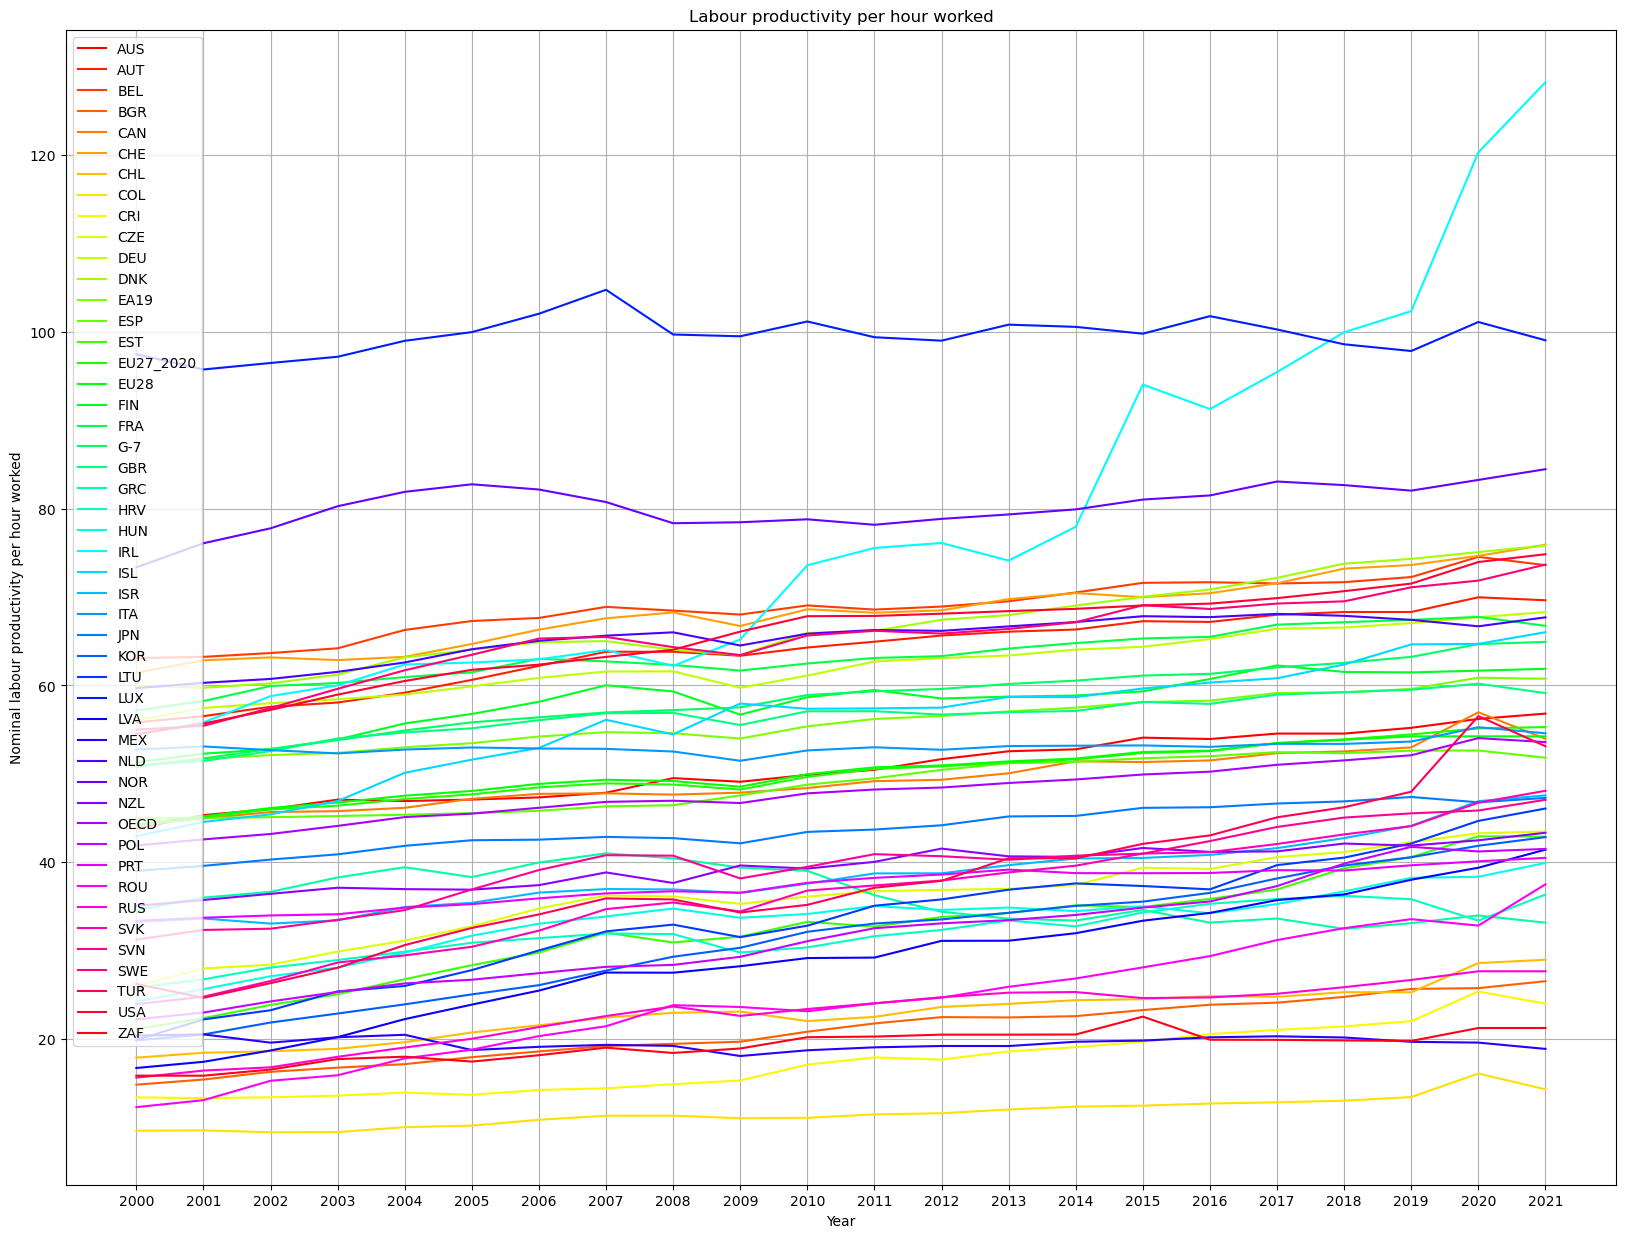

In [224]:
# plots every country throughout time

plt.figure(figsize=(20, 15))

colors = plt.cm.hsv(np.linspace(0, 1, numberOfRows))

for row in range(numberOfRows):
    countryCode = cleanedData.iloc[row][0]
    plt.plot(np.array(cleanedData.columns[1:]), cleanedData.iloc[row][1:], color=colors[row], label=countryCode)

plt.grid()
plt.legend()
plt.xlabel('Year') 
plt.ylabel('Nominal labour productivity per hour worked') 
plt.title("Labour productivity per hour worked")

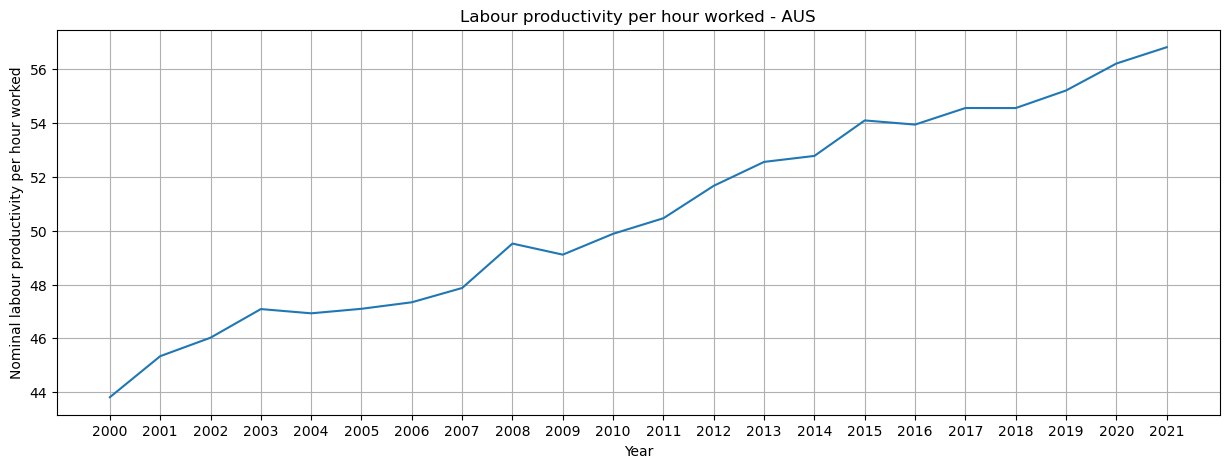

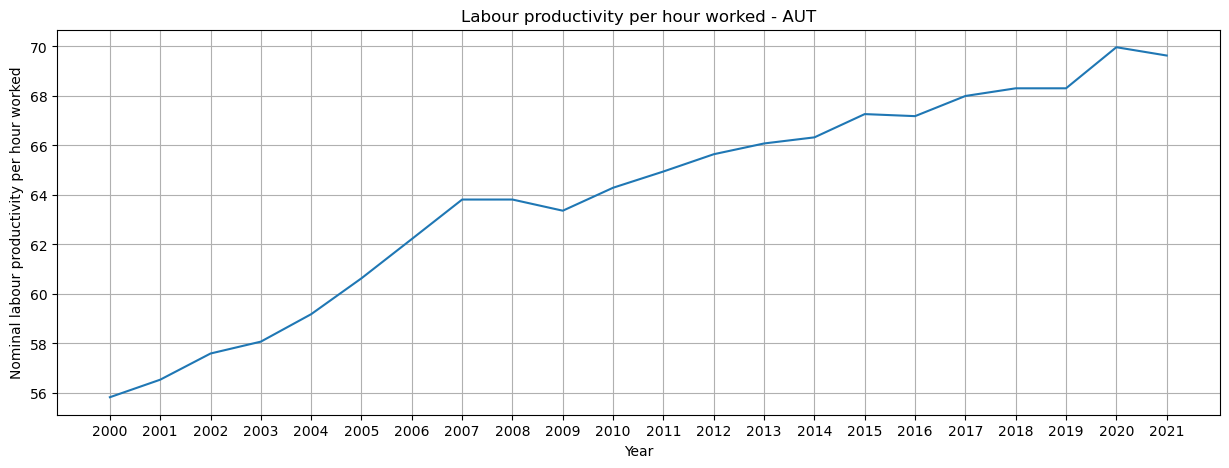

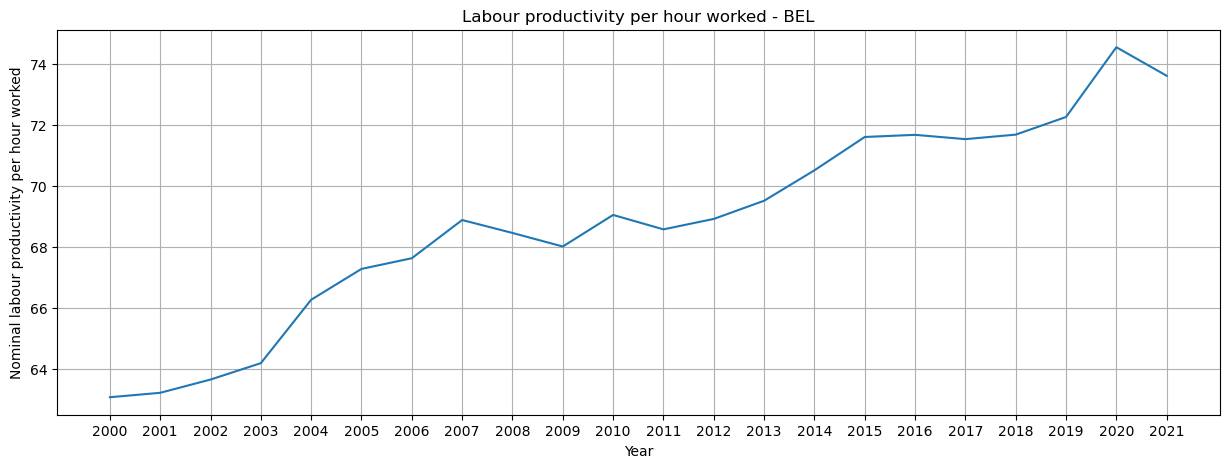

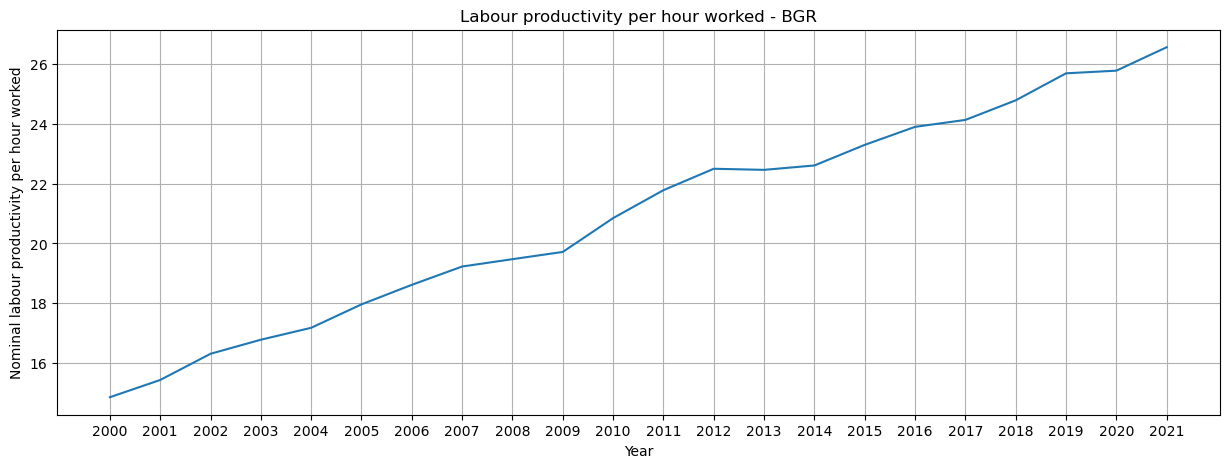

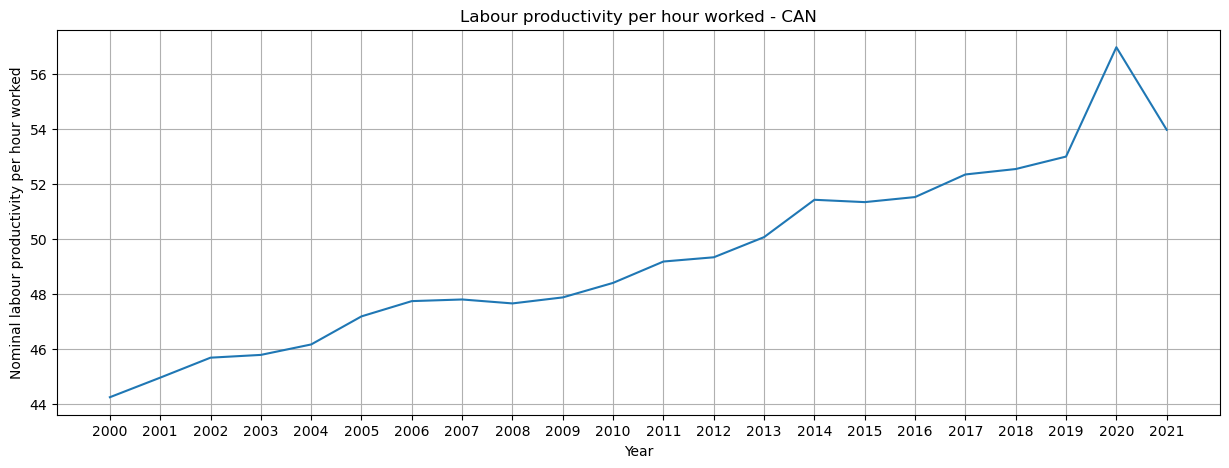

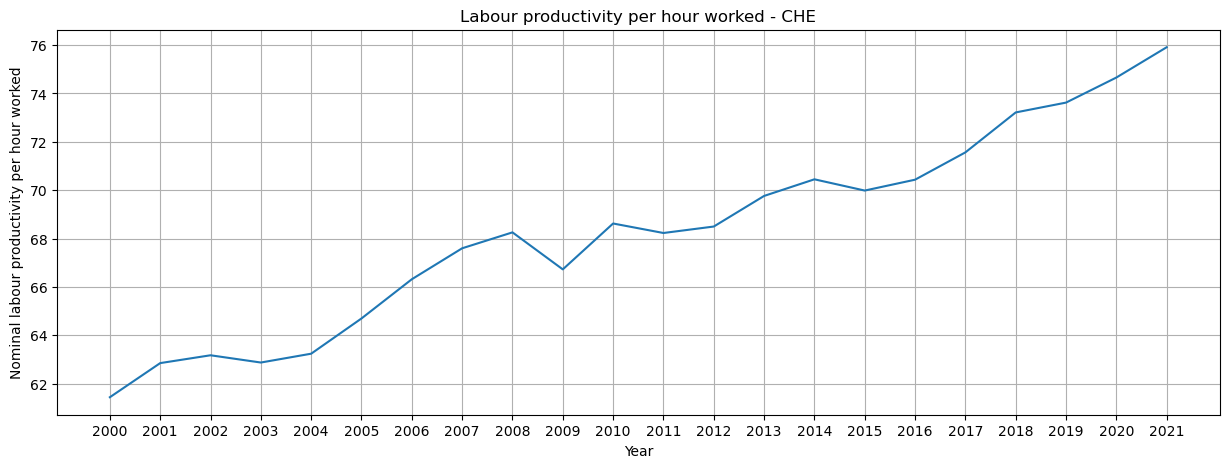

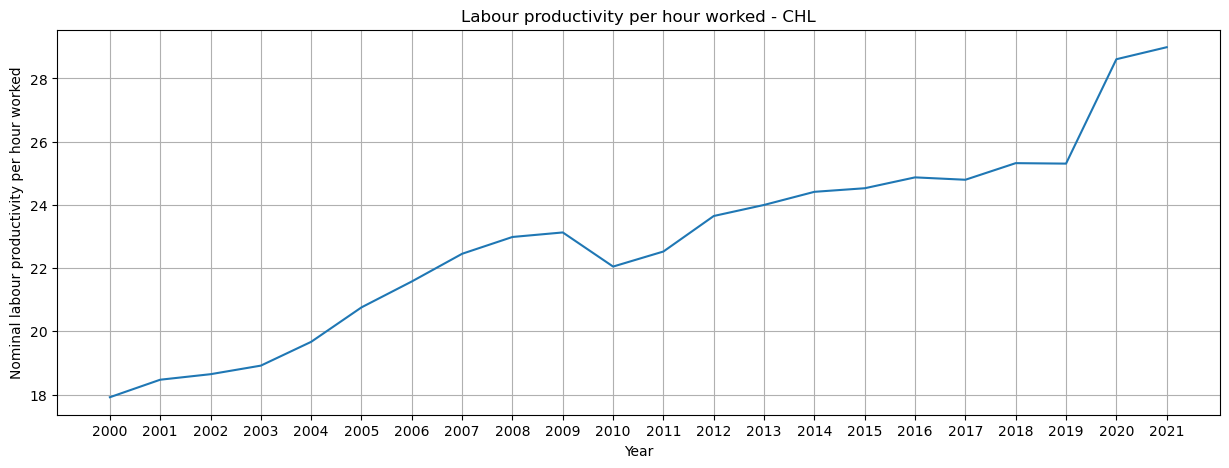

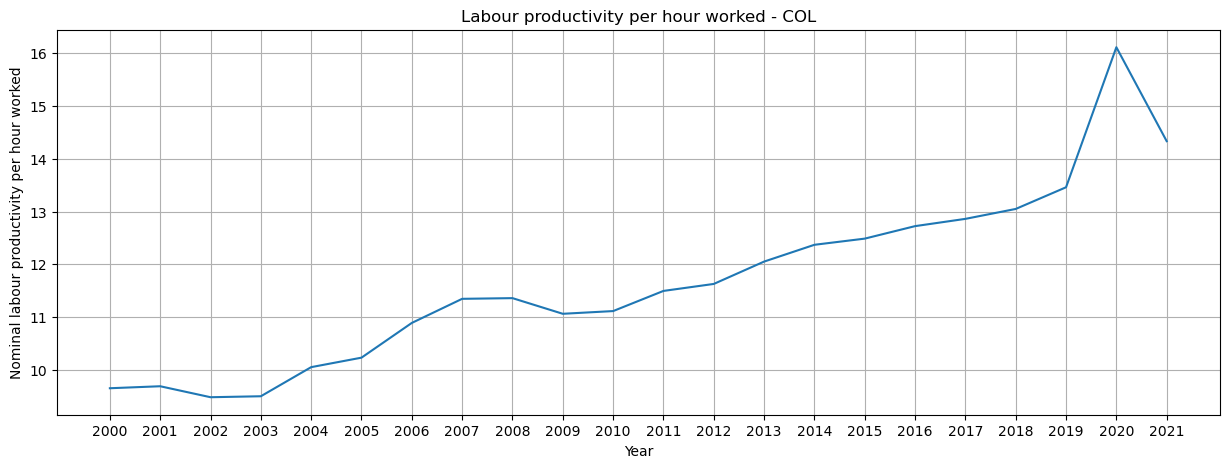

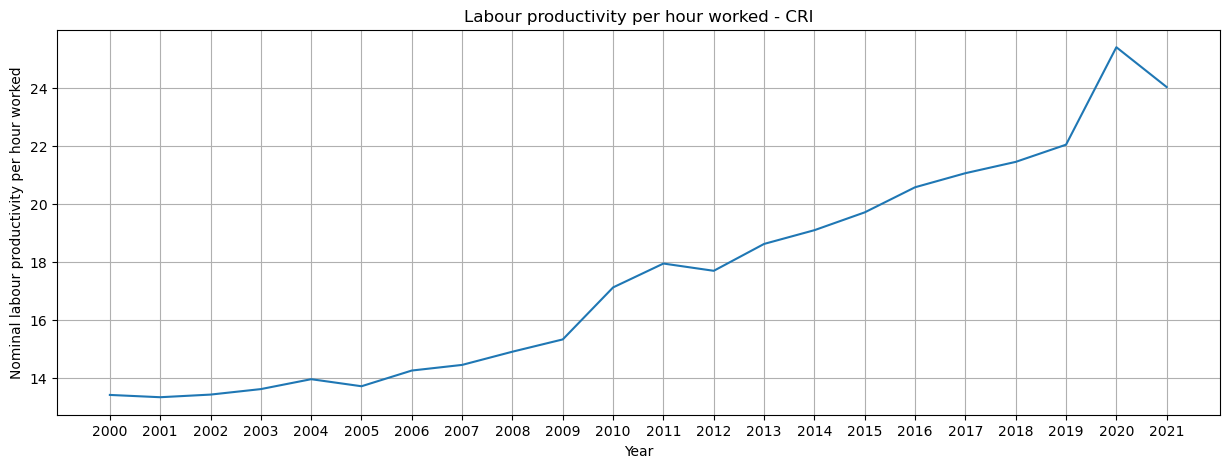

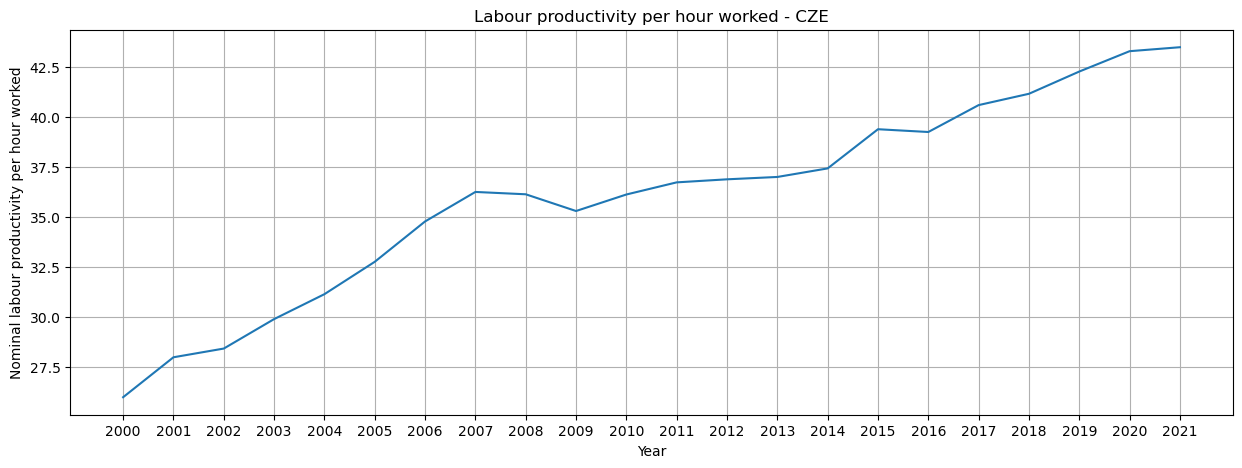

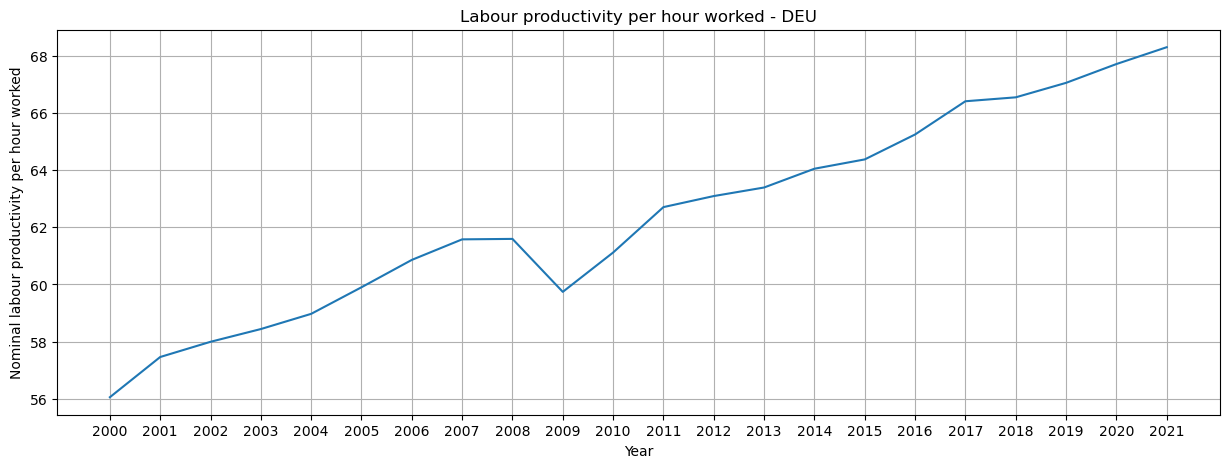

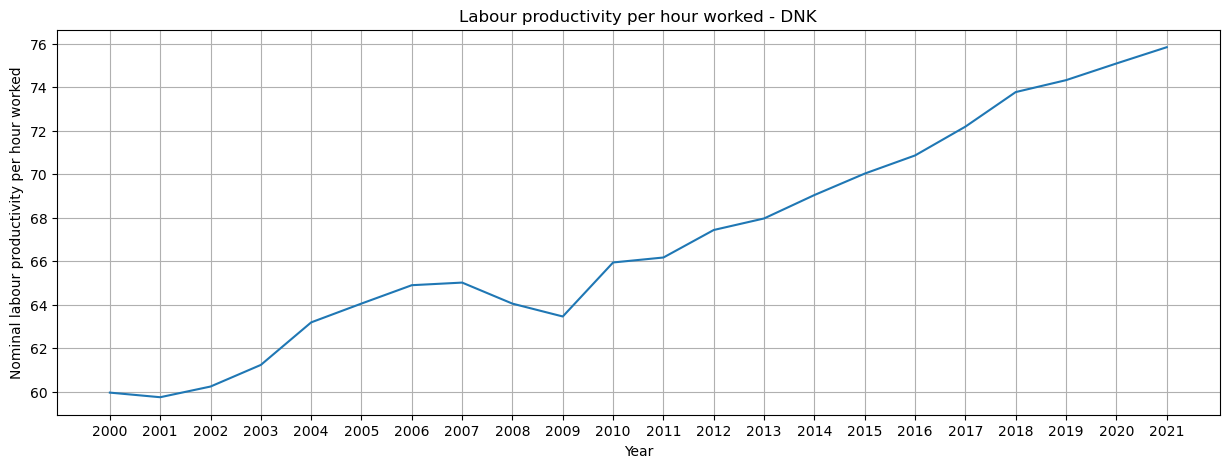

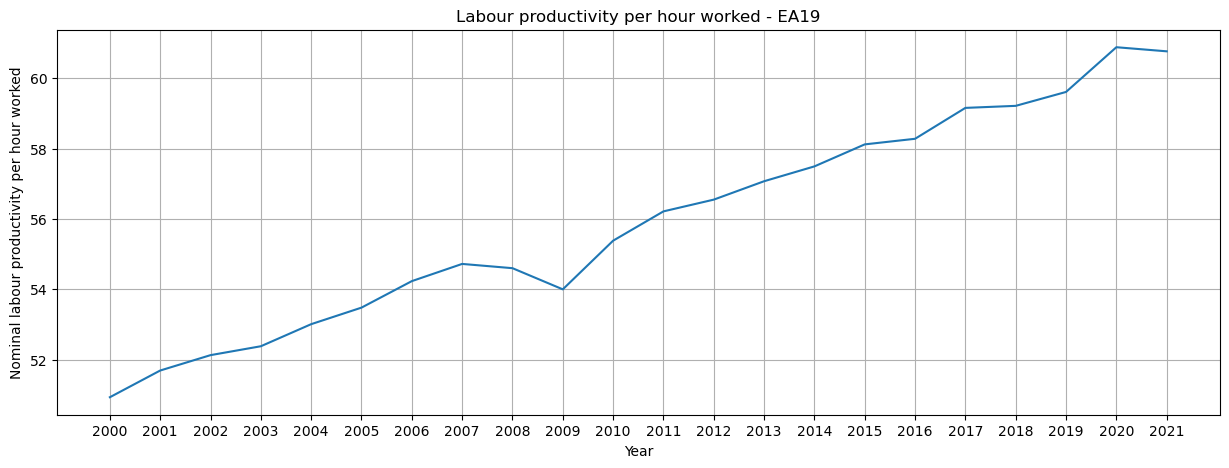

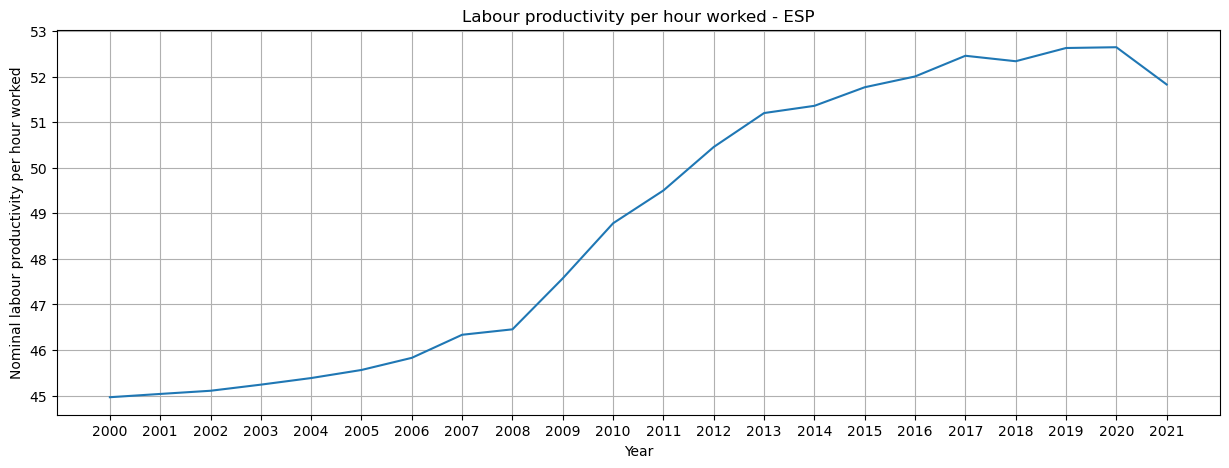

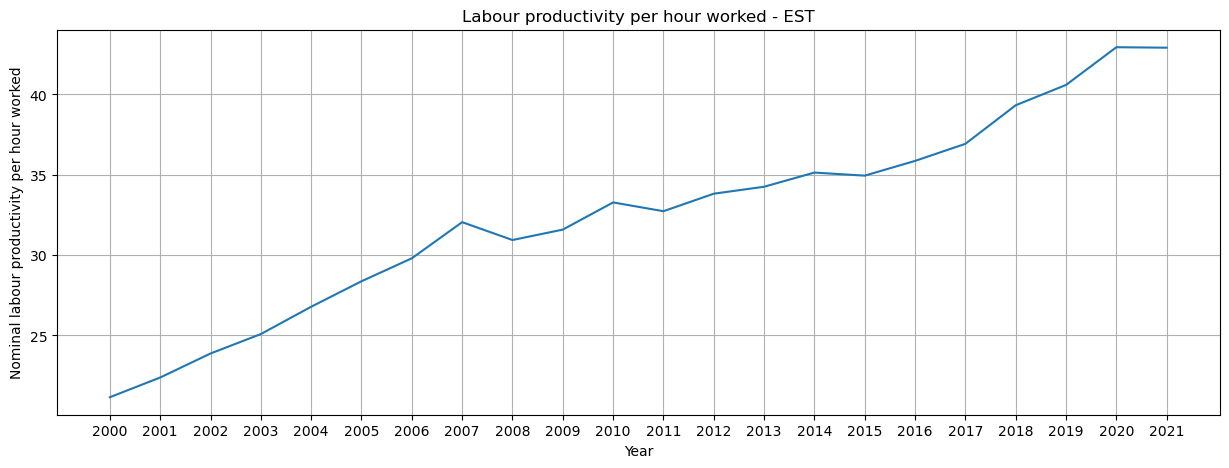

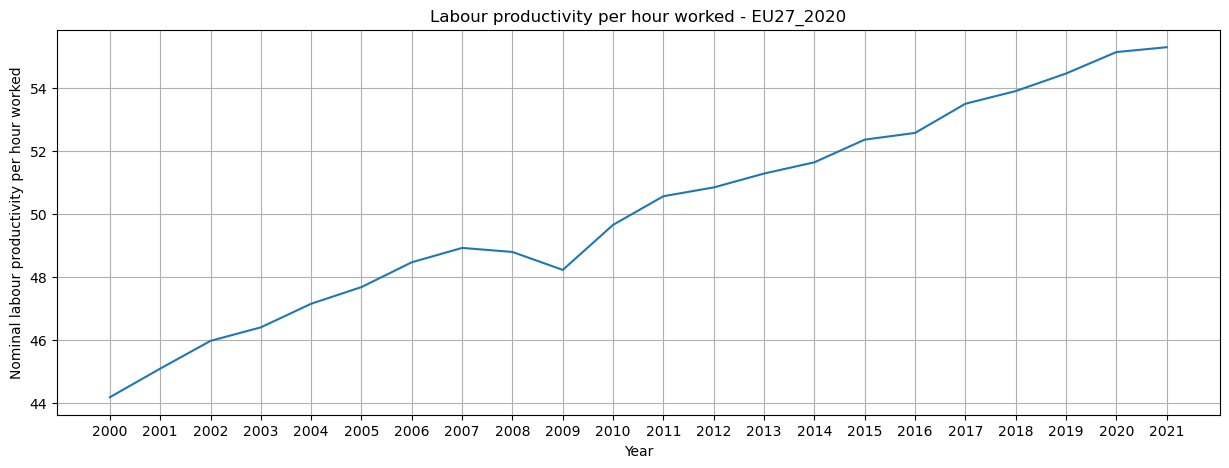

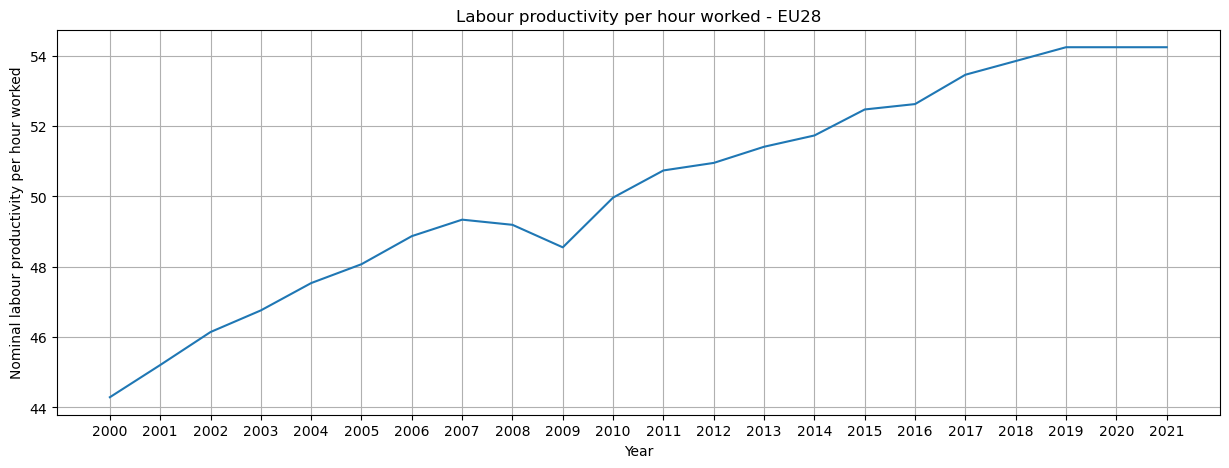

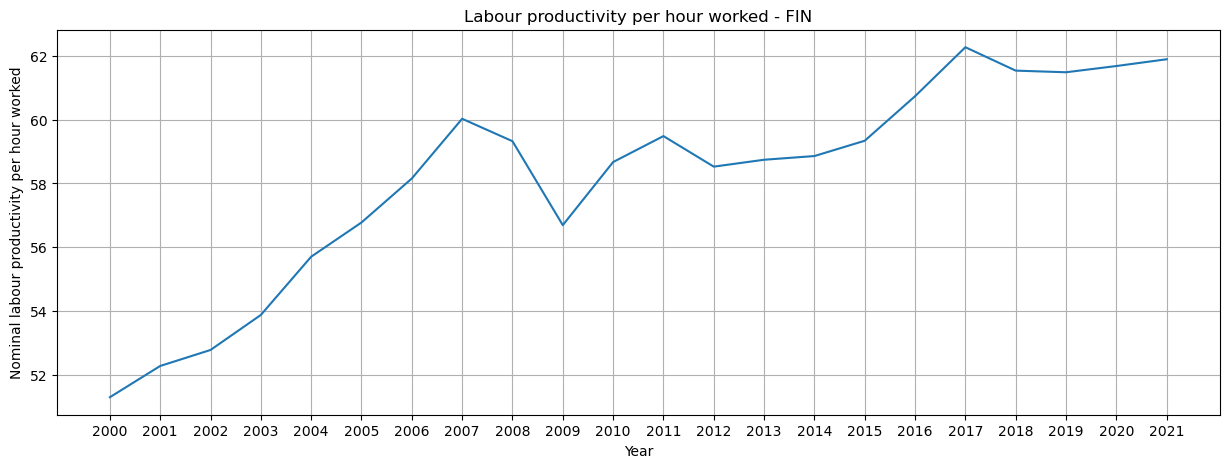

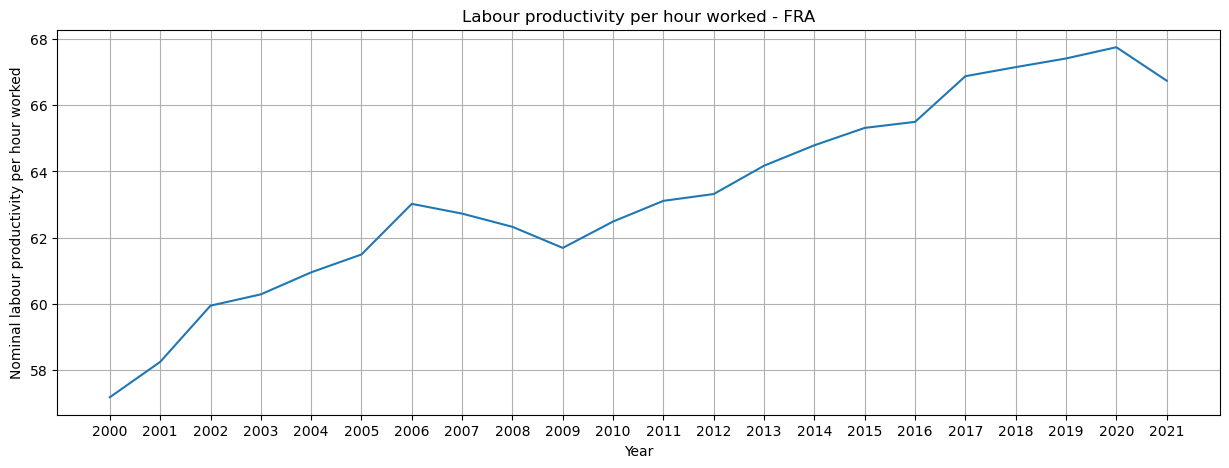

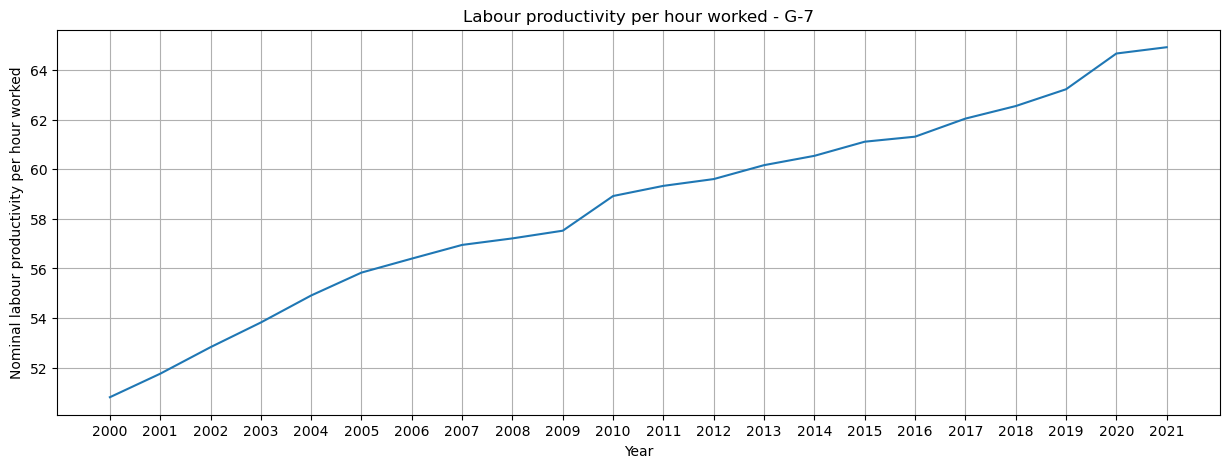

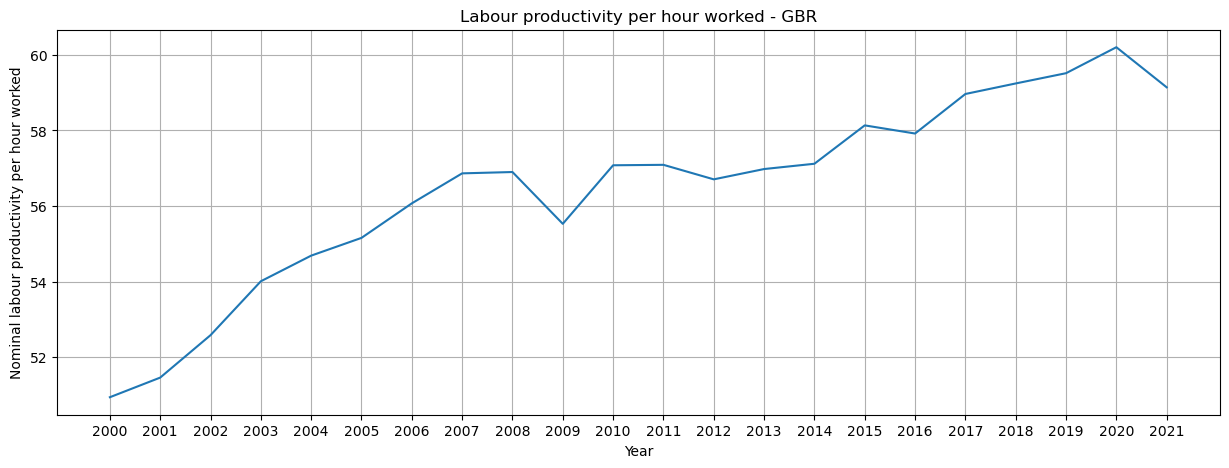

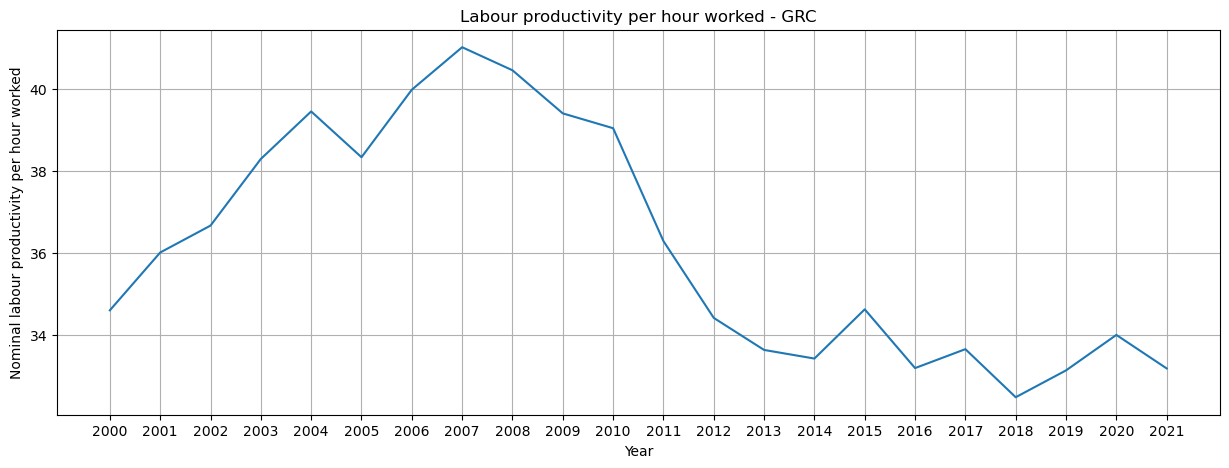

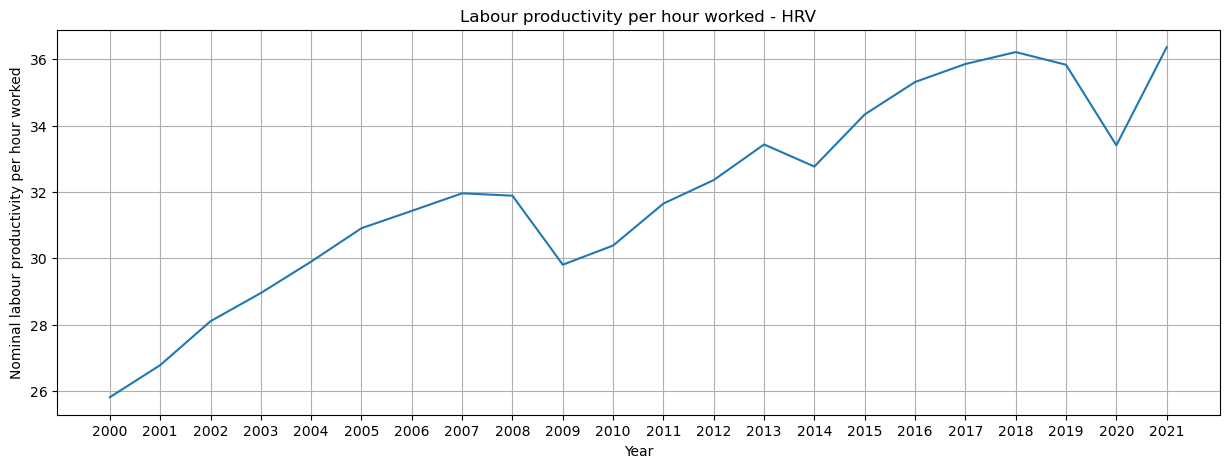

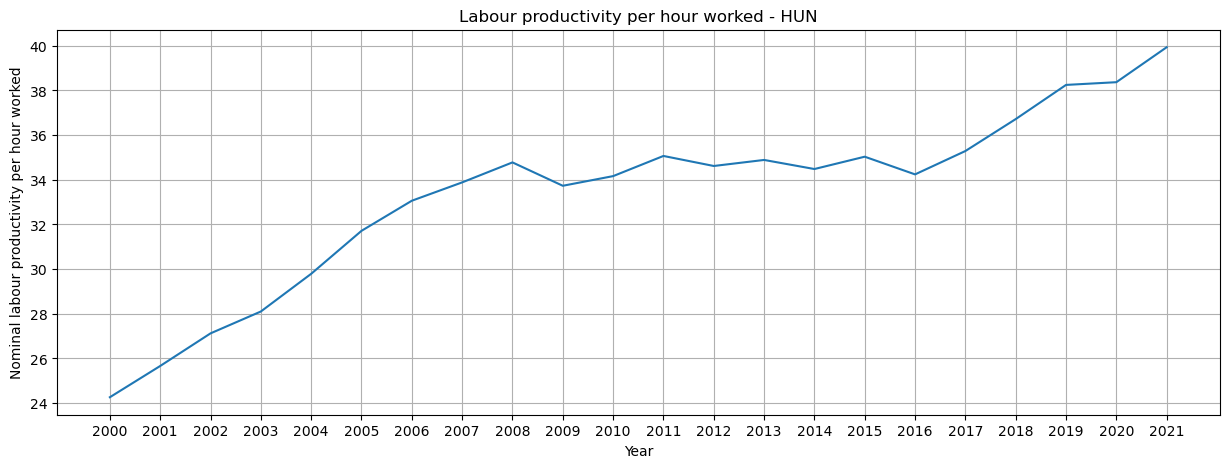

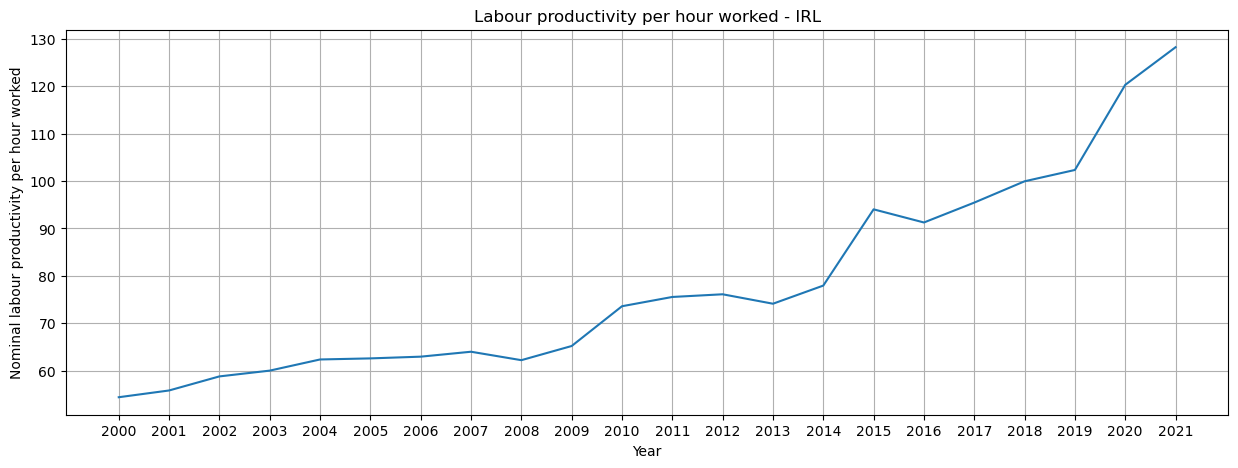

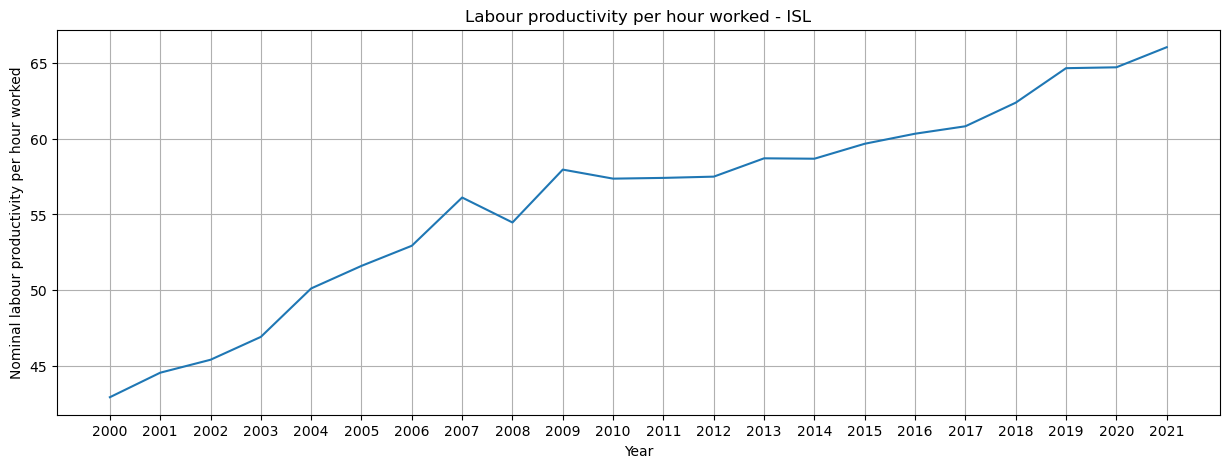

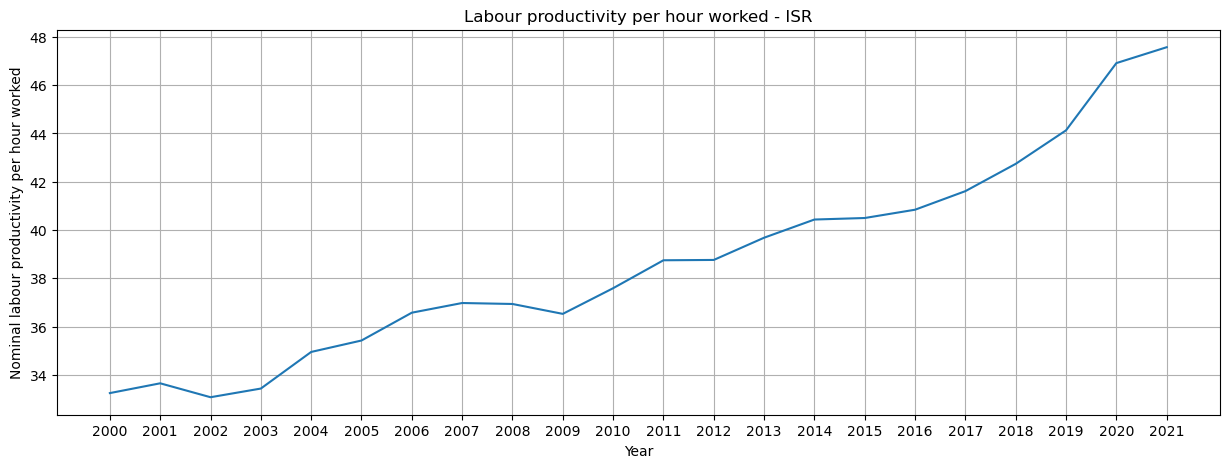

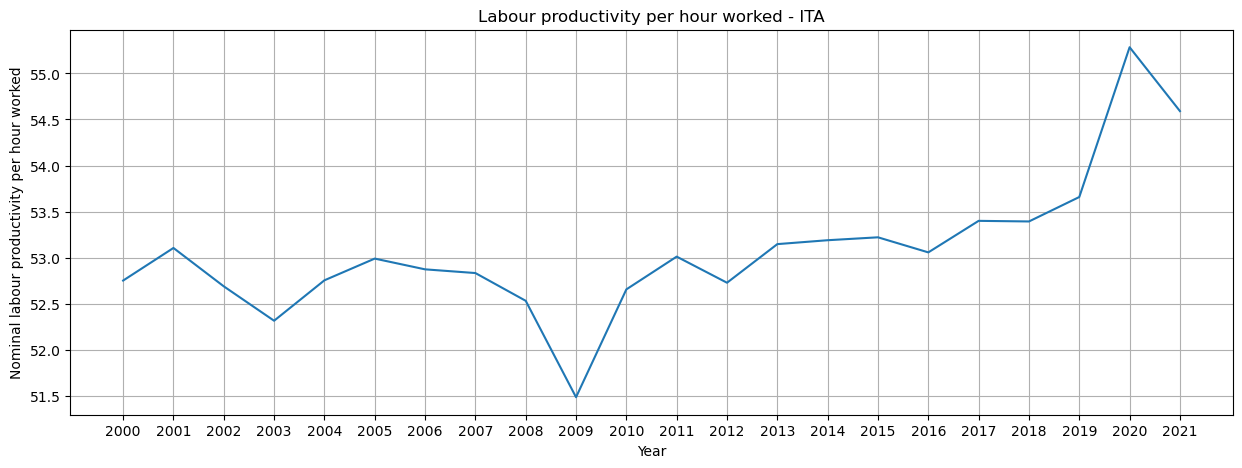

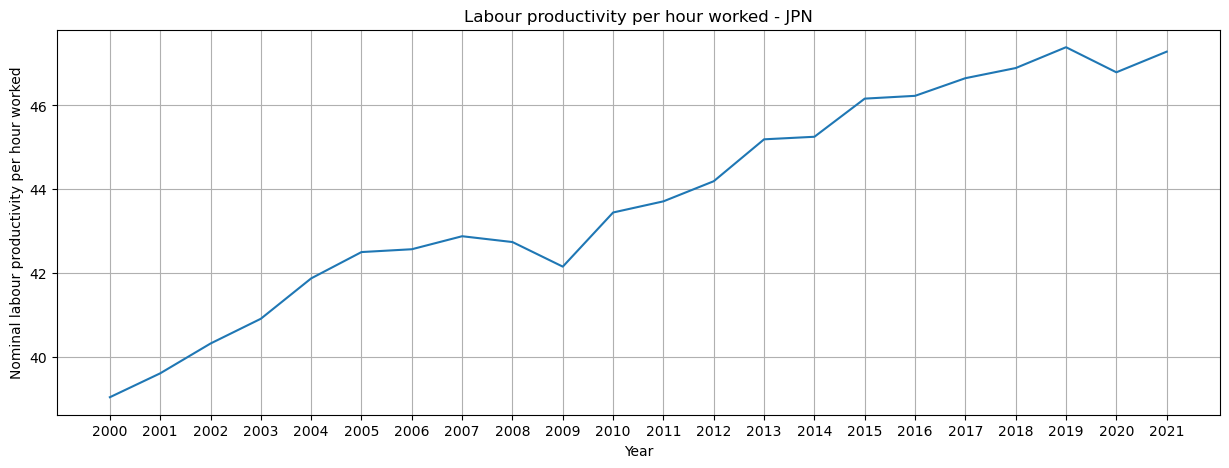

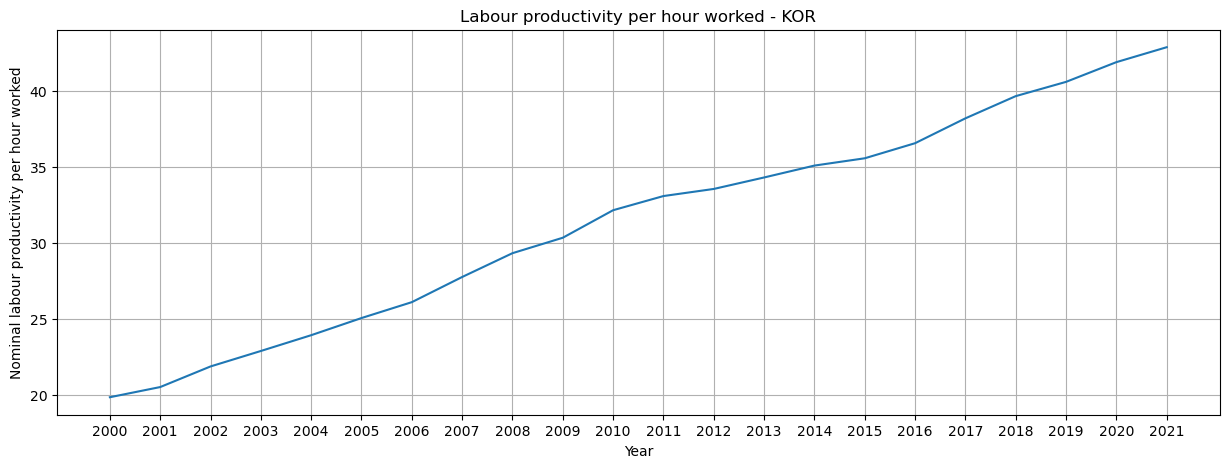

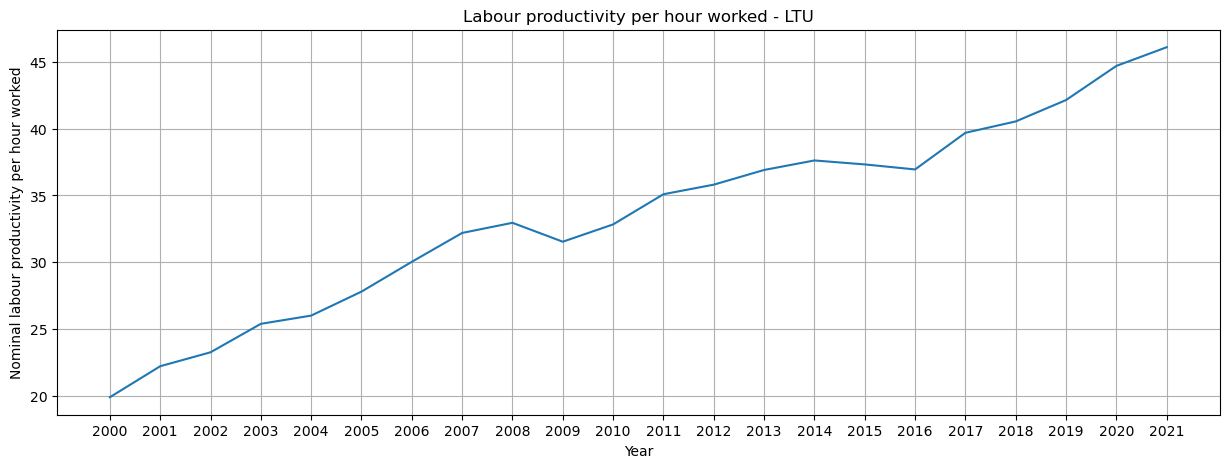

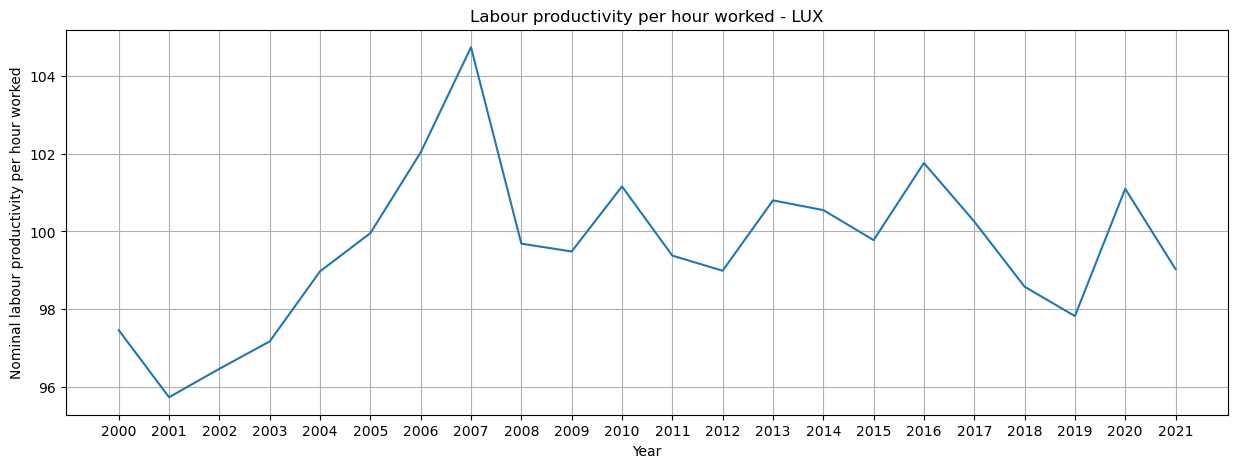

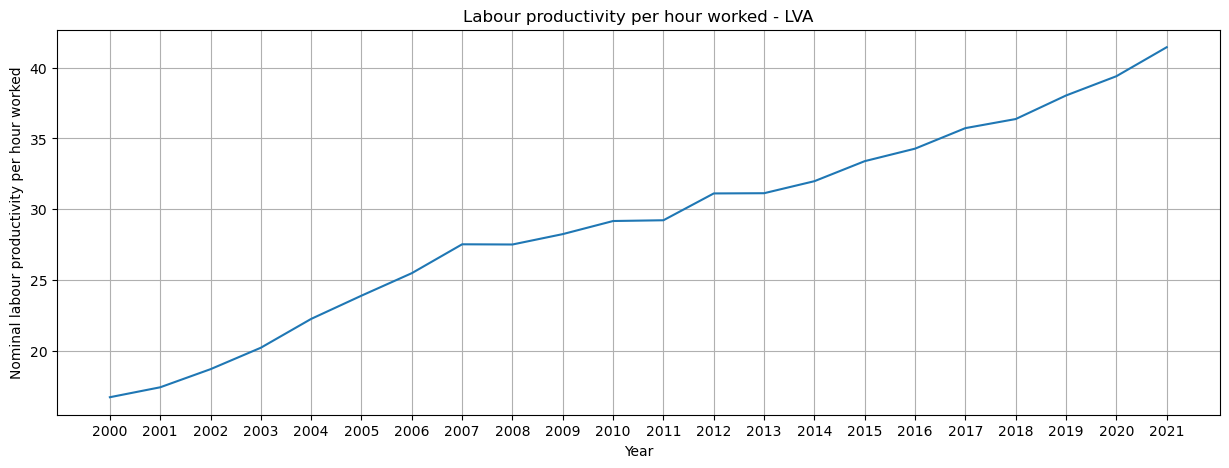

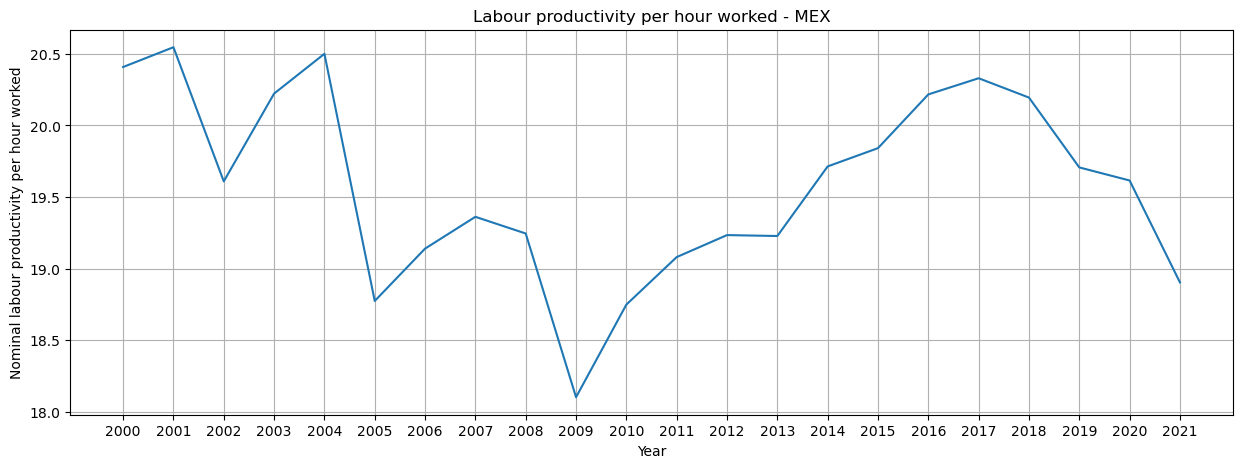

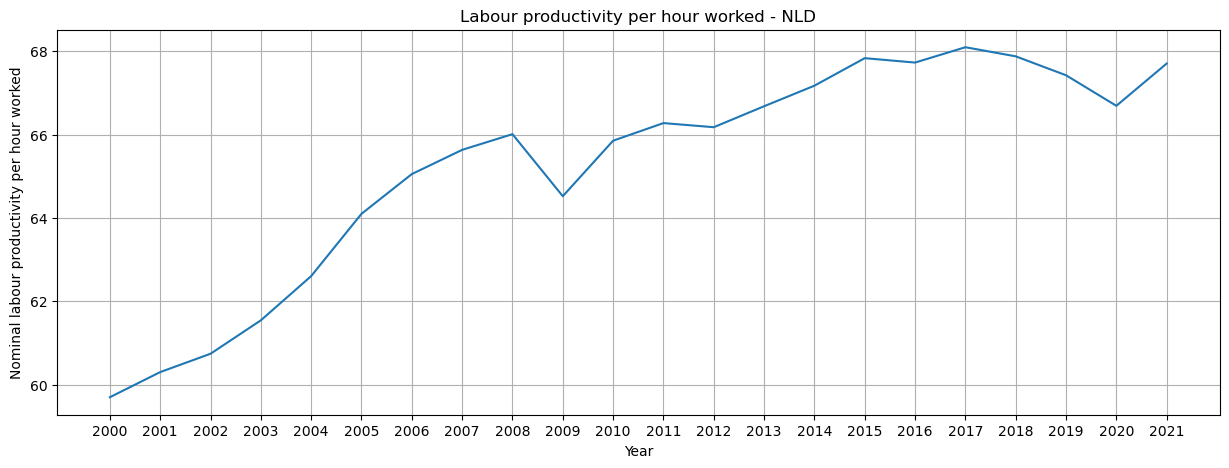

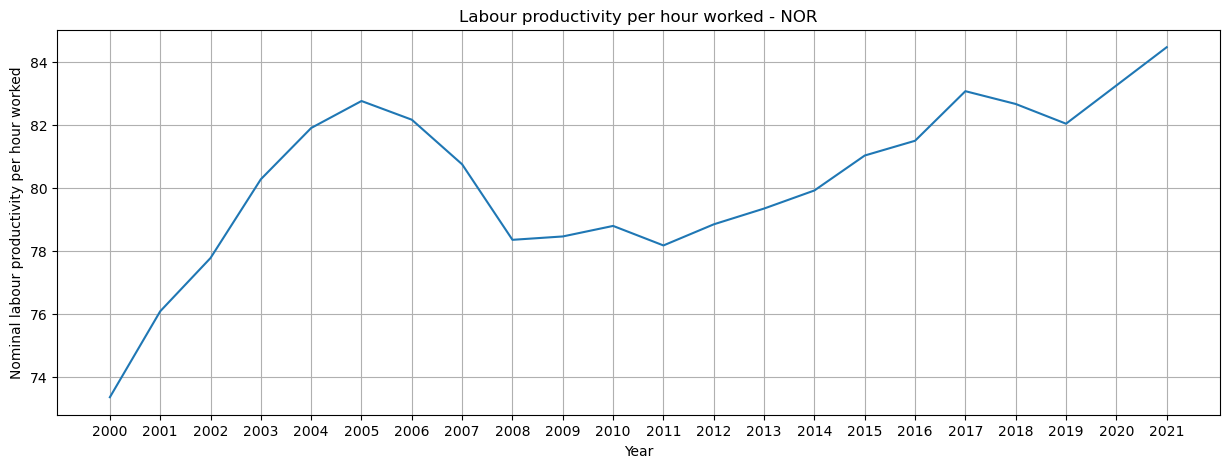

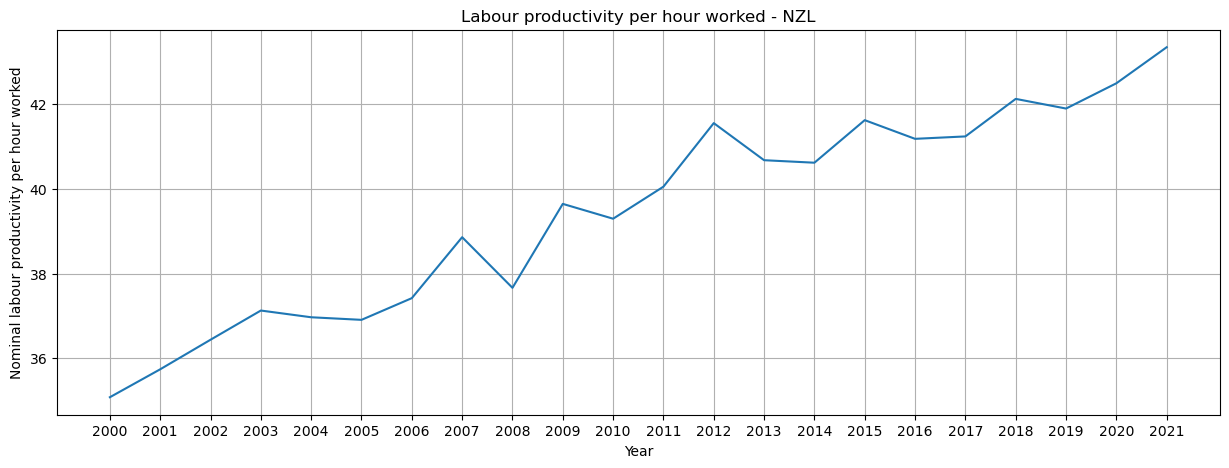

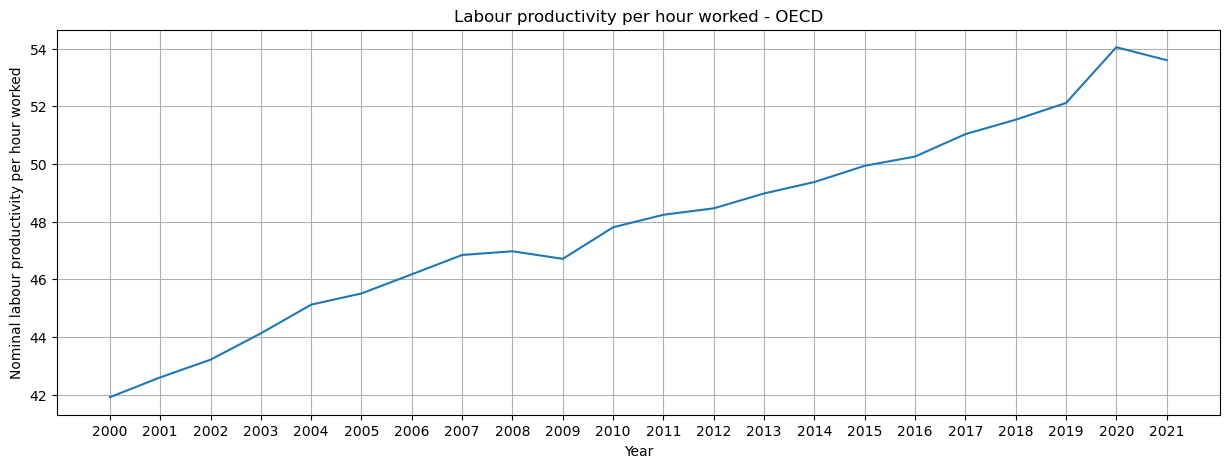

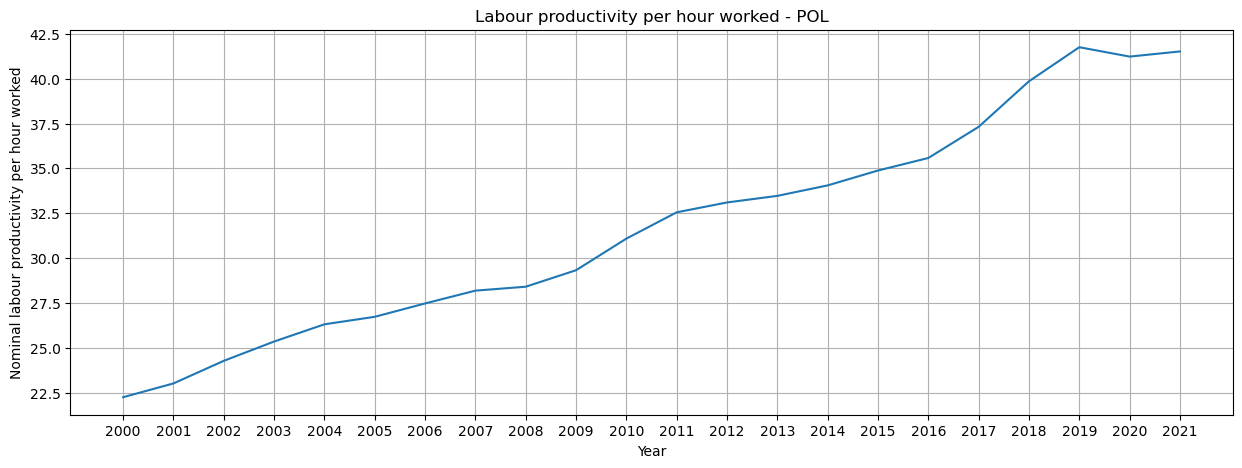

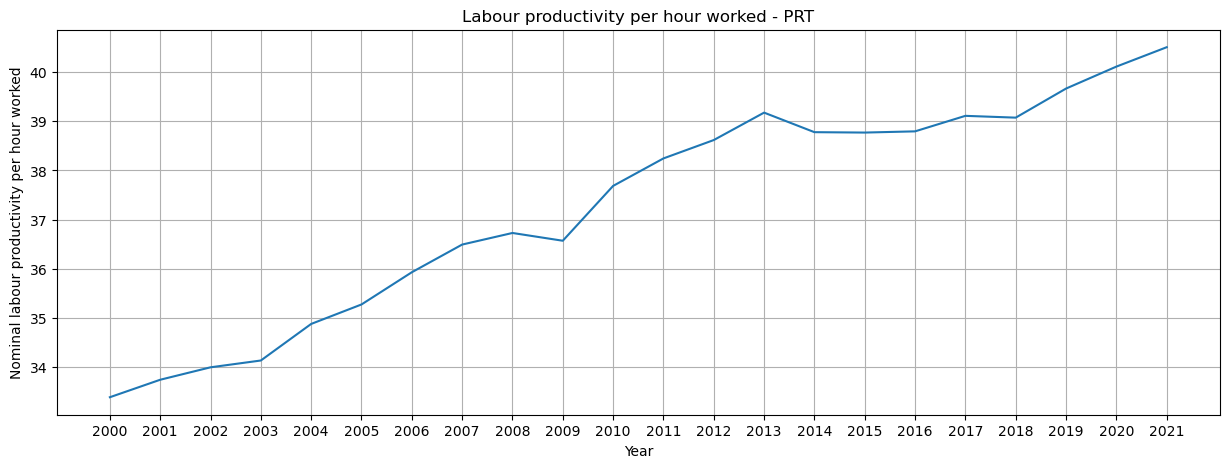

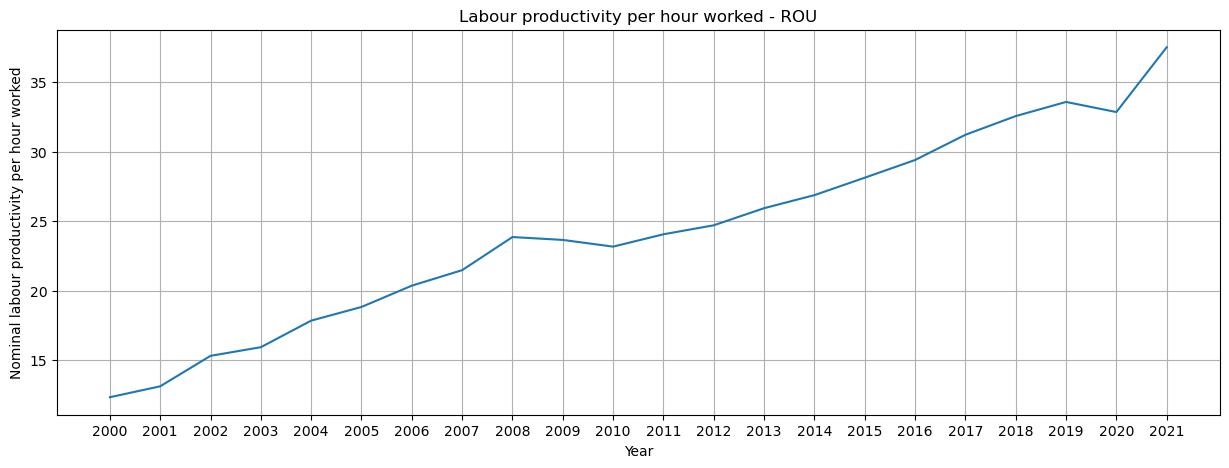

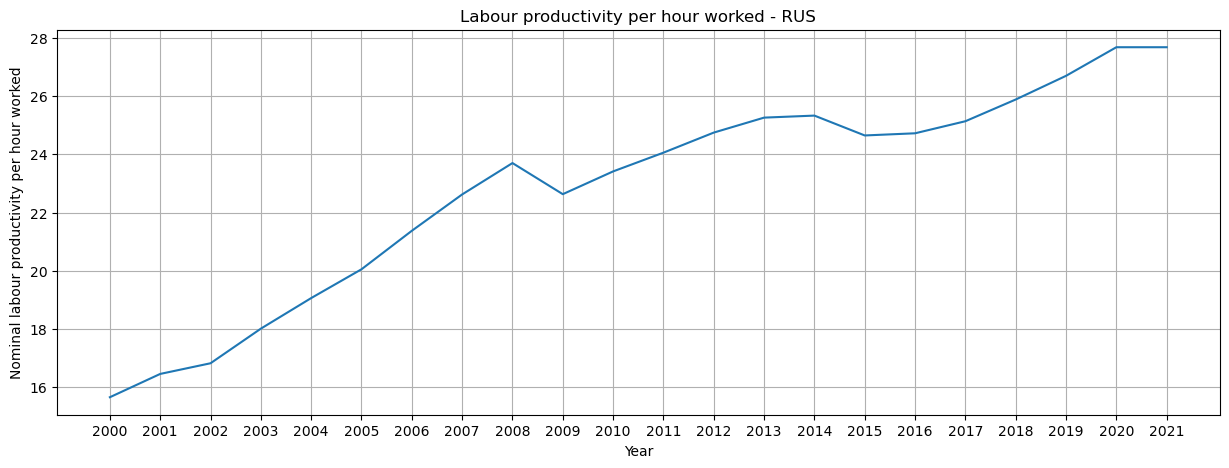

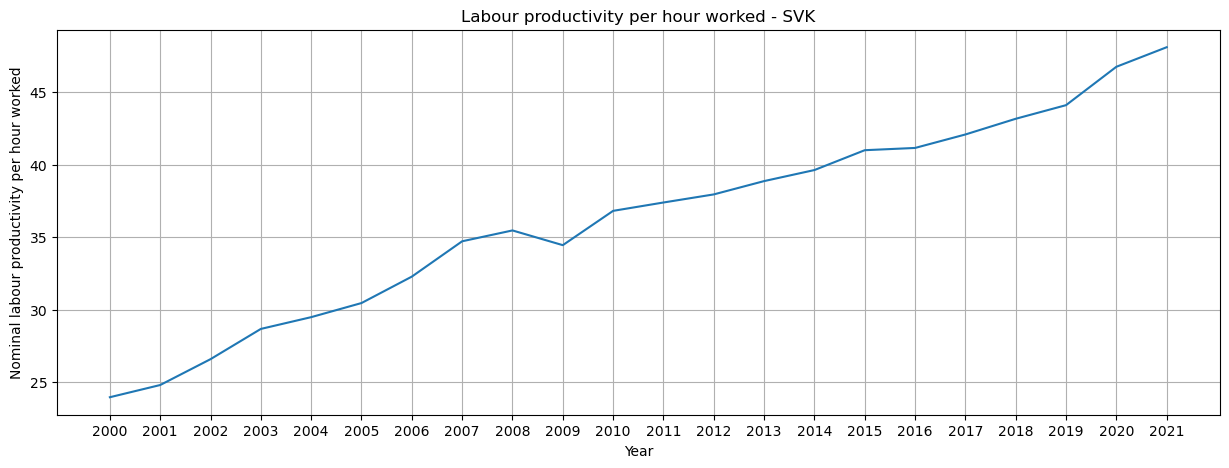

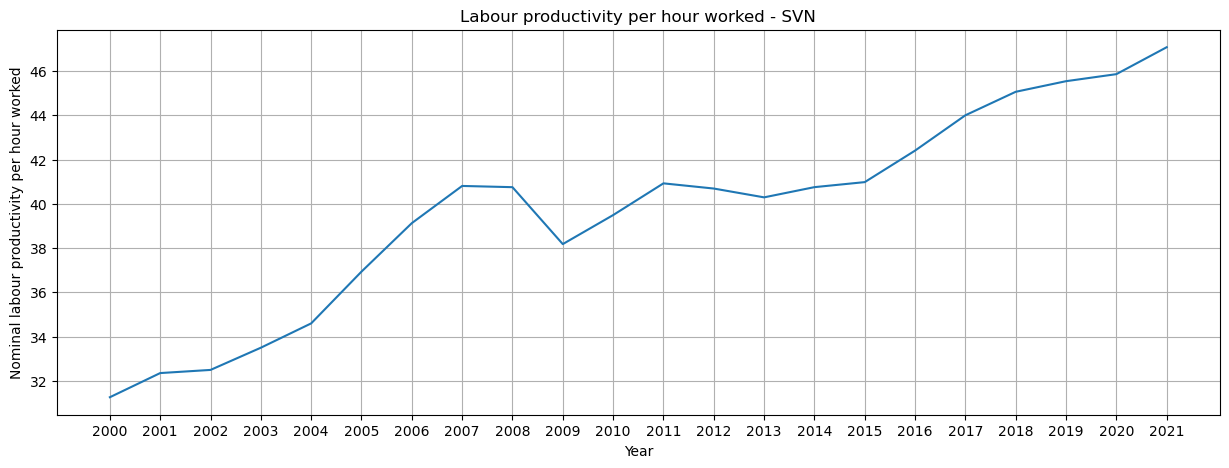

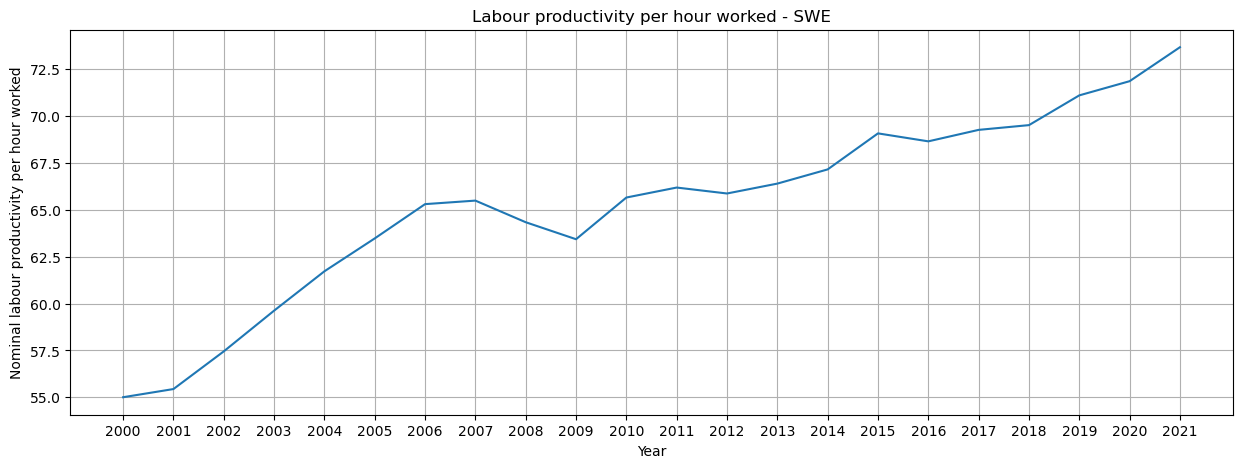

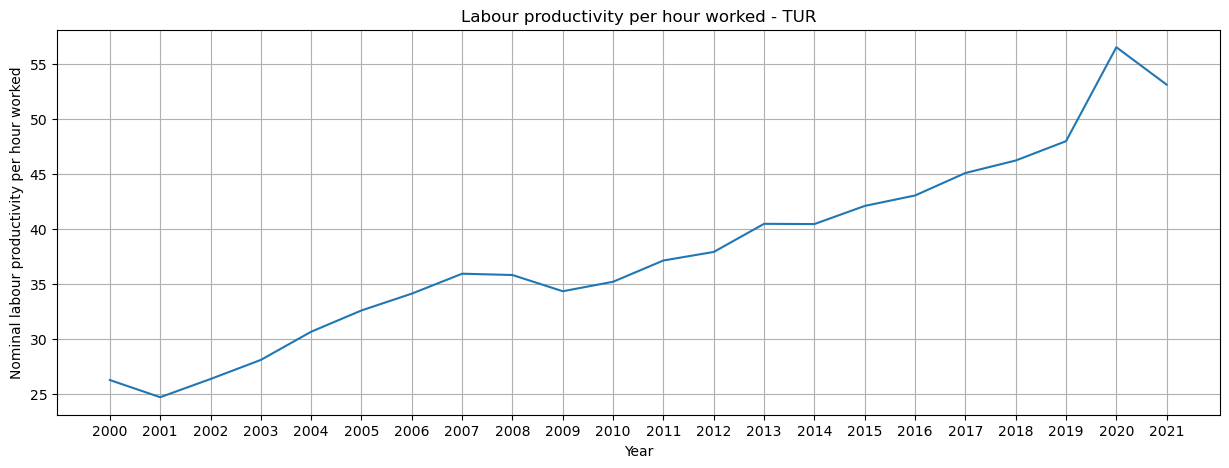

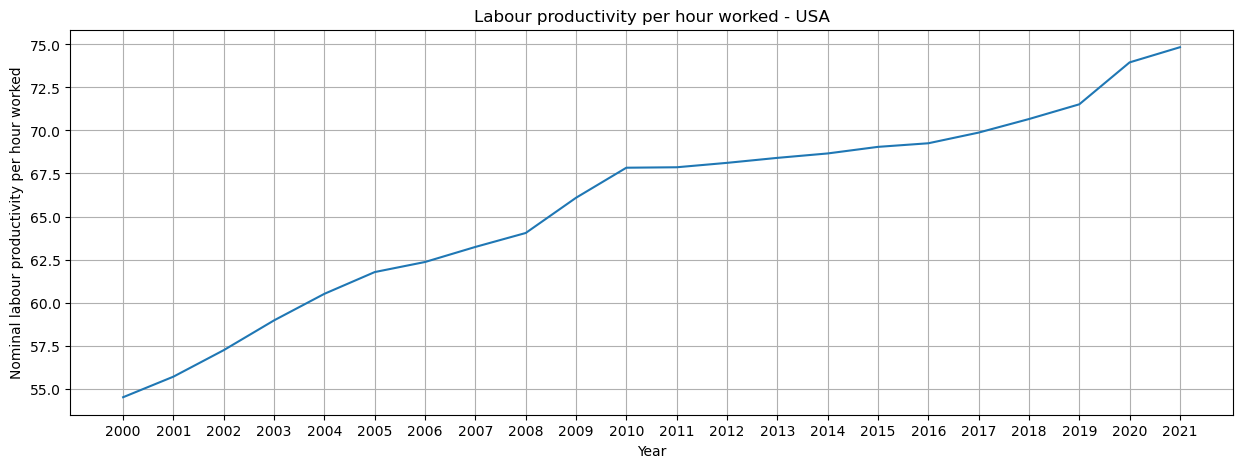

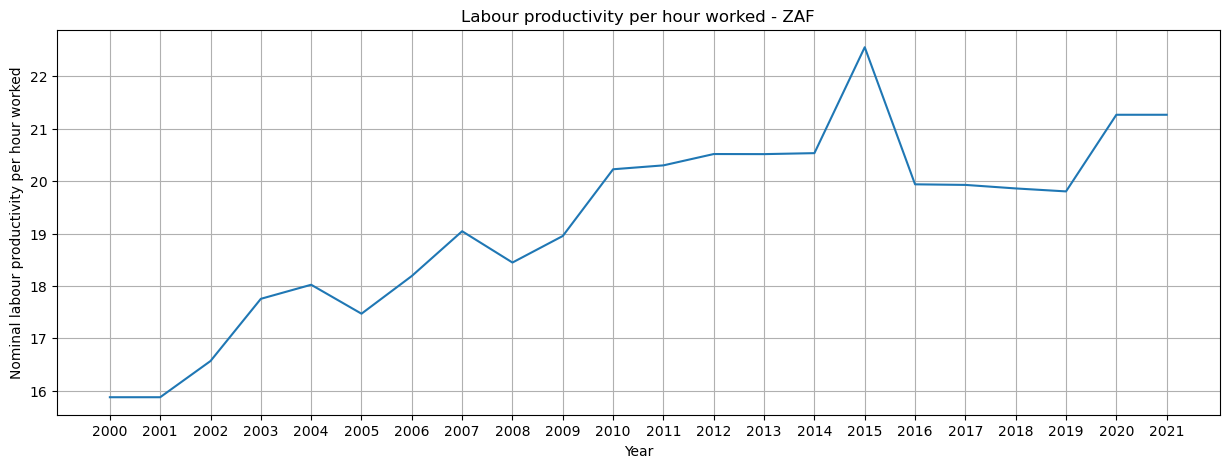

In [225]:
# plots each individual country throughout time

for row in range(numberOfRows):
    plt.figure(figsize=(15, 5))
    countryCode = cleanedData.iloc[row][0]
    plt.plot(np.array(cleanedData.columns[1:]), cleanedData.iloc[row][1:])

    plt.grid()
    plt.xlabel('Year') 
    plt.ylabel('Nominal labour productivity per hour worked') 
    plt.title("Labour productivity per hour worked - " + countryCode)

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Mean labour productivity per hour worked per country - from 2005 to 2021 (inclusive)')

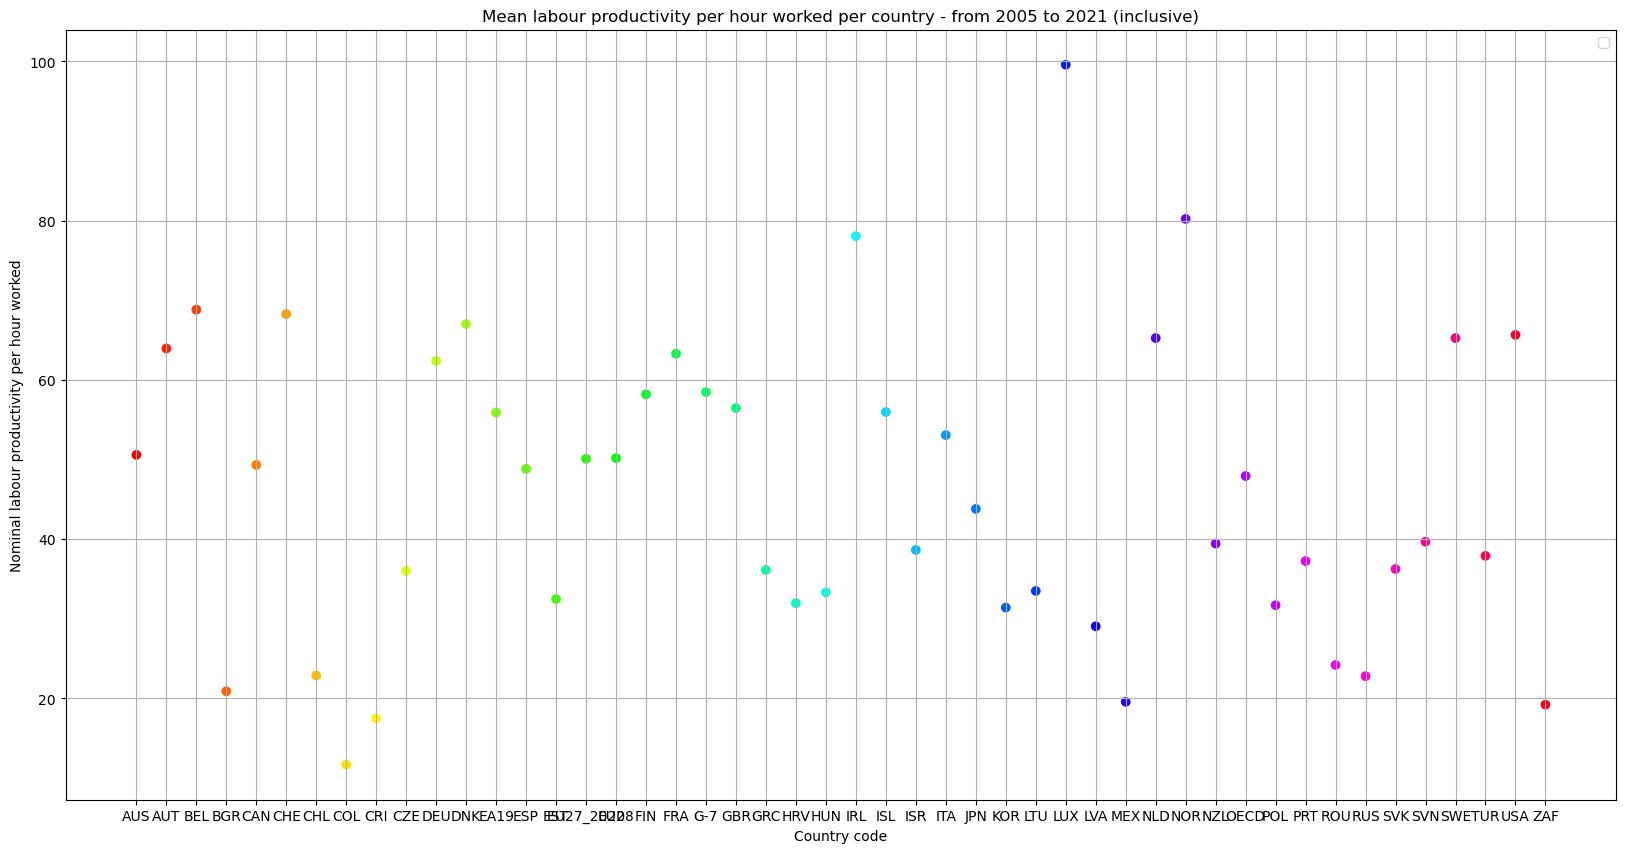

In [227]:
# plots every country's average

plt.figure(figsize=(20, 10))

countryCodesPHW = []
countryMeansPHW = []

for row in range(numberOfRows):
    countryCode = cleanedData.iloc[row][0]
    countryCodesPHW.append(countryCode)
    countryMeansPHW.append(float(np.mean(cleanedData.iloc[row][1:])))

"""print(countryCodesPHW)
print(len(countryCodesPHW))"""

cleanedData['mean'] = countryMeansPHW

plt.scatter(cleanedData['LOCATION'], countryMeansPHW, c=colors)
plt.grid()

plt.legend()
plt.xlabel('Country code') 
plt.ylabel('Nominal labour productivity per hour worked') 
plt.title("Mean labour productivity per hour worked per country - from 2005 to 2021 (inclusive)")

/var/folders/jv/flhd9_611gvdf13cfv1w9t640000gn/T/ipykernel_3592/66970801.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(countryCodesPHW[countryMeansPHW.index(sortedcountryMeansPHW[row])], sortedcountryMeansPHW[row], c=colors[row])


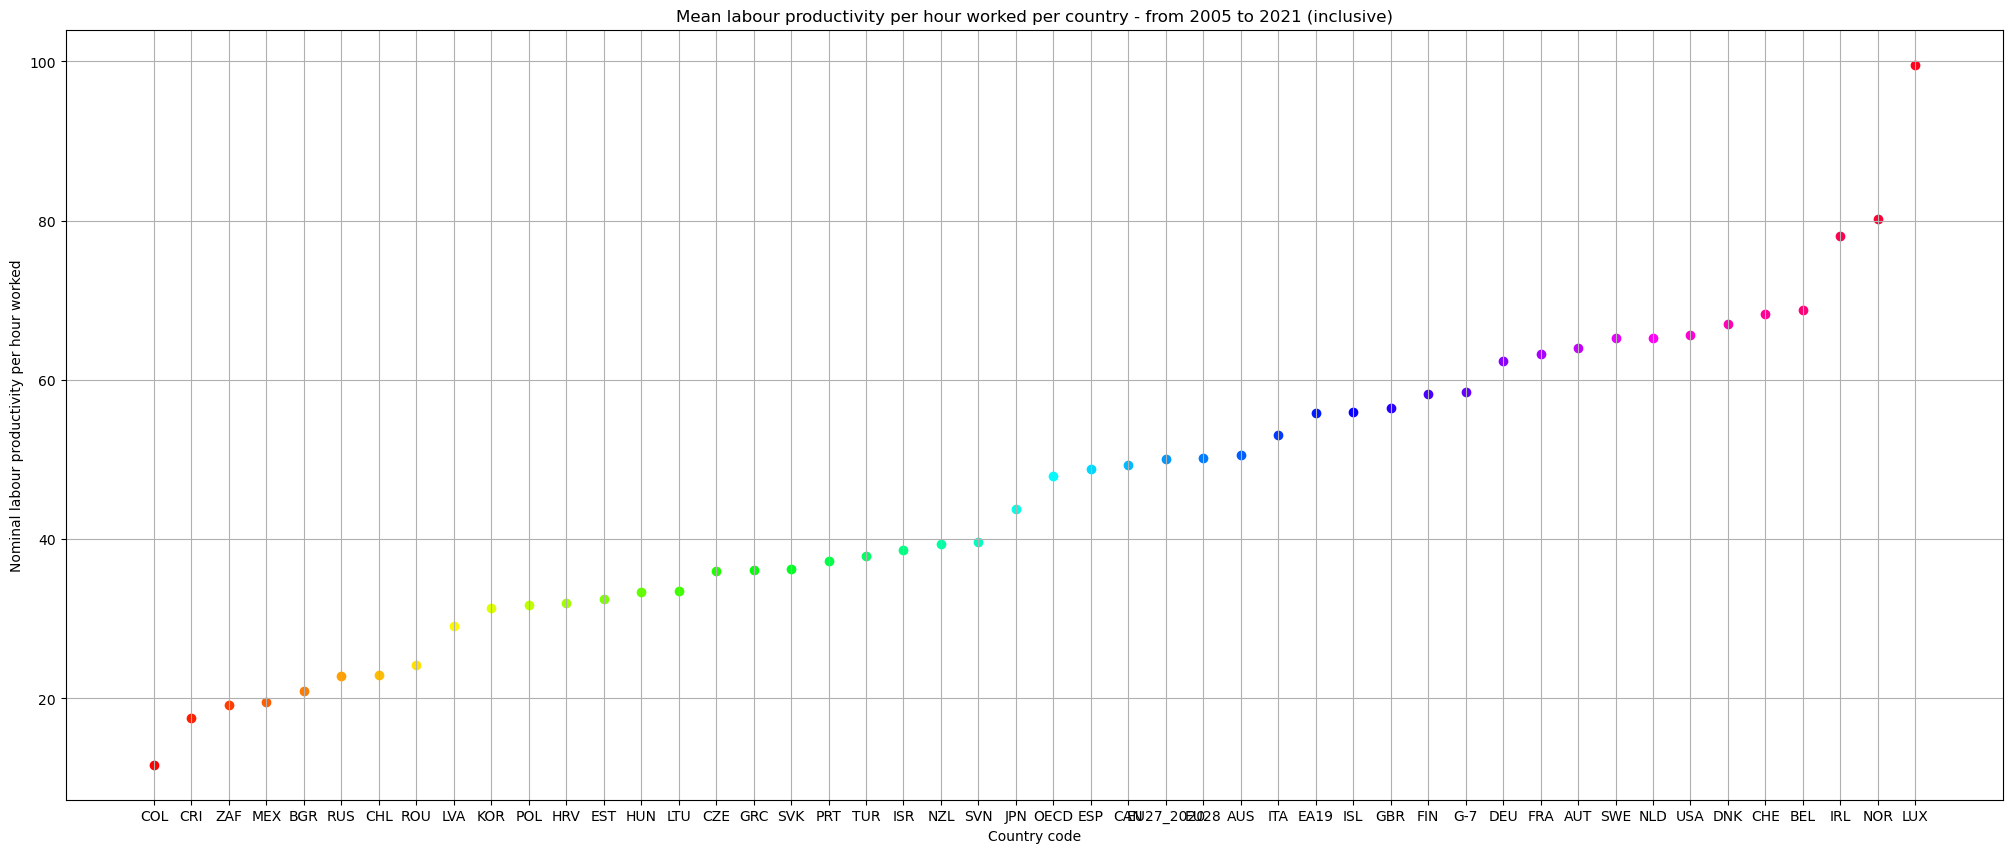

In [231]:
# plots every country's average - ordered

plt.figure(figsize=(25, 10))

sortedcountryMeansPHW = np.sort(countryMeansPHW)

for row in range(numberOfRows):
    plt.scatter(countryCodesPHW[countryMeansPHW.index(sortedcountryMeansPHW[row])], sortedcountryMeansPHW[row], c=colors[row])

plt.grid()

plt.xlabel('Country code') 
plt.ylabel('Nominal labour productivity per hour worked') 
plt.title("Mean labour productivity per hour worked per country - from 2005 to 2021 (inclusive)")
plt.show()

In [233]:
Australia = 'AUS'
Austria = 'AUT'
Belgium = 'BEL'
Bulgaria = 'BGR'
Canada = 'CAN'
Switzerland = 'CHE'
Chile = 'CHL'
Colombia = 'COL'
CostaRica = 'CRI'
CzechRepublic = 'CZE'
Germany = 'DEU'
Denmark = 'DNK'
EuroArea19Countries = 'EA19'
Spain = 'ESP'
Estonia = 'EST'
EuropeanUnion27Countries = 'EU27_2020' #From 01_02_2020
EuropeanUnion28Countries = 'EU28' #Until 01_02_2020
Finland = 'FIN'
France = 'FRA'
G7 = 'G-7'
UnitedKingdom = 'GBR'
Greece = 'GRC'
Croatia = 'HRV'
Hungary = 'HUN'
Ireland = 'IRL'
Iceland = 'ISL'
Israel = 'ISR'
Italy = 'ITA'
Japan = 'JPN'
Korea = 'KOR'
Lithuania = 'LTU'
Luxembourg = 'LUX'
Latvia = 'LVA'
Mexico = 'MEX'
Netherlands = 'NLD'
Norway = 'NOR'
NewZealand = 'NZL'
OECD_total = 'OECD'
Poland = 'POL'
Portugal = 'PRT'
Romania = 'ROU'
Russia = 'RUS'
Slovakia = 'SVK'
Slovenia = 'SVN'
Sweden = 'SWE'
Turkey = 'TUR'
UnitedStates = 'USA'
SouthAfrica = 'ZAF'

In [344]:
# accordignly to https://www.cia.gov/the-world-factbook/field/location/

CentralEurope = [Austria, CzechRepublic, Germany, Hungary, Poland, Slovakia, Slovenia, Switzerland]
EasternEurope = [Estonia, Latvia, Lithuania]
NorthernEurope = [Denmark, Finland, Norway, Sweden, Iceland]
SouthEasternEurope = [Bulgaria, Croatia, Romania, Turkey]
SouthernEurope = [Greece, Italy]
SouthWesternEurope = [Portugal, Spain]
WesternEurope = [Belgium, France, Ireland, Luxembourg, Netherlands, UnitedKingdom]

Europe = [CentralEurope, EasternEurope, NorthernEurope, SouthEasternEurope, SouthernEurope, SouthWesternEurope, WesternEurope]
EuropeFlat =  [country for subregion in Europe for country in subregion]
print(EuropeFlat)

NorthAmerica = [Mexico, UnitedStates, Canada, CostaRica]
SouthAmerica = [Chile, Colombia]
Africa = [SouthAfrica]
Oceania = [Australia, NewZealand]
Asia = [Japan, Korea, Russia, Israel]

worldRegions = [EuropeFlat, NorthAmerica, SouthAmerica, Africa, Oceania, Asia]
print(len(worldRegions))

aggregatedMeasures = [EuroArea19Countries, EuropeanUnion27Countries, EuropeanUnion28Countries, G7, OECD_total]

print(len(CentralEurope)+len(EasternEurope)+len(NorthernEurope)+len(SouthEasternEurope)+len(SouthernEurope)+len(SouthWesternEurope)+len(WesternEurope)+
      len(Oceania)+len(NorthAmerica)+len(SouthAmerica)+len(Asia)+len(Africa)+
      len(aggregatedMeasures))

['AUT', 'CZE', 'DEU', 'HUN', 'POL', 'SVK', 'SVN', 'CHE', 'EST', 'LVA', 'LTU', 'DNK', 'FIN', 'NOR', 'SWE', 'ISL', 'BGR', 'HRV', 'ROU', 'TUR', 'GRC', 'ITA', 'PRT', 'ESP', 'BEL', 'FRA', 'IRL', 'LUX', 'NLD', 'GBR']
6
48


In [295]:
# computes the mean of each european region

worldRegionMeans = []
europeMeans = []

for region in Europe:
    mean = 0
    count = 0

    for country in region:
        if country in countryCodesPHW:
            mean += float(cleanedData.loc[cleanedData['LOCATION'] == country]['mean'])
            count += 1

    mean = mean/count
    europeMeans.append(mean)

worldRegionMeans.append(np.mean(europeMeans))

In [296]:
print(europeMeans)
print(worldRegionMeans)

[46.45260696022727, 31.686116757575757, 65.33018876363636, 28.748082181818184, 44.61121679545455, 43.04876102272728, 71.91539377272727]
[47.39890946488095]


In [297]:
# computes the mean of the remaining world regions

NorthAmerica = [Mexico, UnitedStates, Canada, CostaRica]
SouthAmerica = [Chile, Colombia]
Africa = [SouthAfrica]
Oceania = [Australia, NewZealand]
Asia = [Japan, Korea, Russia, Israel]

NorthAmericaMeans = []
SouthAmericaMeans = []
AfricaMeans = []
OceaniaMeans = []
AsiaMeans = []
restOfTheWorldMeans = [NorthAmericaMeans, SouthAmericaMeans, AfricaMeans, OceaniaMeans, AsiaMeans]

for index, region in enumerate(worldRegions[1:]):
    mean = 0
    count = 0

    for country in region:
        if country in countryCodesPHW:
            countryMean = float(cleanedData.loc[cleanedData['LOCATION'] == country]['mean'])
            restOfTheWorldMeans[index].append(countryMean)
            mean += countryMean
            count += 1

    mean = mean/count
    worldRegionMeans.append(mean)

In [298]:
print(restOfTheWorldMeans)

[[19.57793090909091, 65.65653804545454, 49.328641409090906, 17.507325318181817], [22.887997227272727, 11.680666454545454], [19.222794681818183], [50.587458590909094, 39.45284918181817], [43.8056835909091, 31.413973545454546, 22.802442727272727, 38.650926545454546]]


In [299]:
print(worldRegionMeans)

[47.39890946488095, 38.01760892045454, 17.28433184090909, 19.222794681818183, 45.02015388636363, 34.168256602272734]


[47.39890946488095, 38.01760892045454, 17.28433184090909, 19.222794681818183, 45.02015388636363, 34.168256602272734]


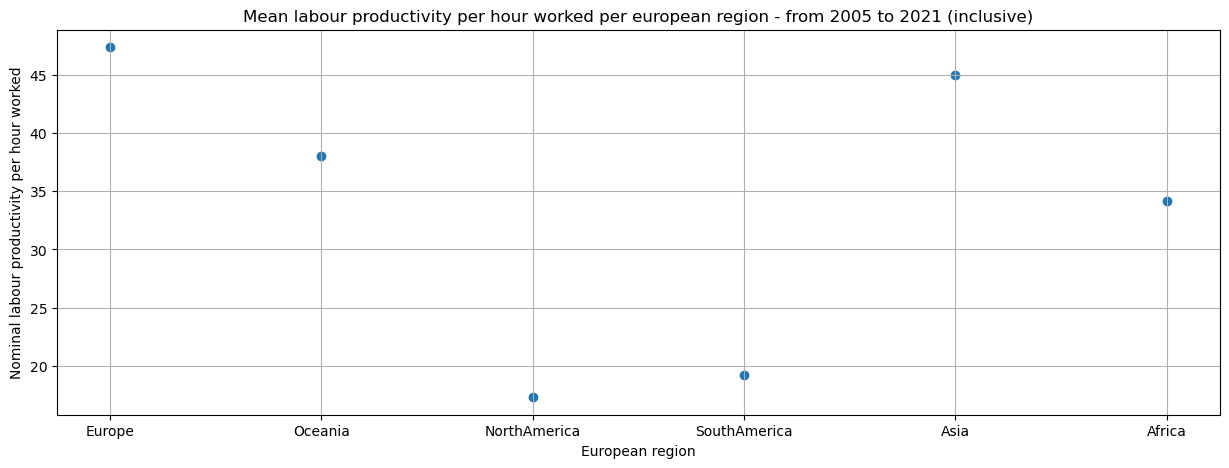

In [300]:
# plots the mean of every european region

plt.figure(figsize=(15, 5))

print(worldRegionMeans)

plt.scatter(['Europe', 'Oceania', 'NorthAmerica', 'SouthAmerica', 'Asia', 'Africa'], worldRegionMeans)

plt.grid()

plt.xlabel('European region') 
plt.ylabel('Nominal labour productivity per hour worked') 
plt.title("Mean labour productivity per hour worked per european region - from 2005 to 2021 (inclusive)")
plt.show()

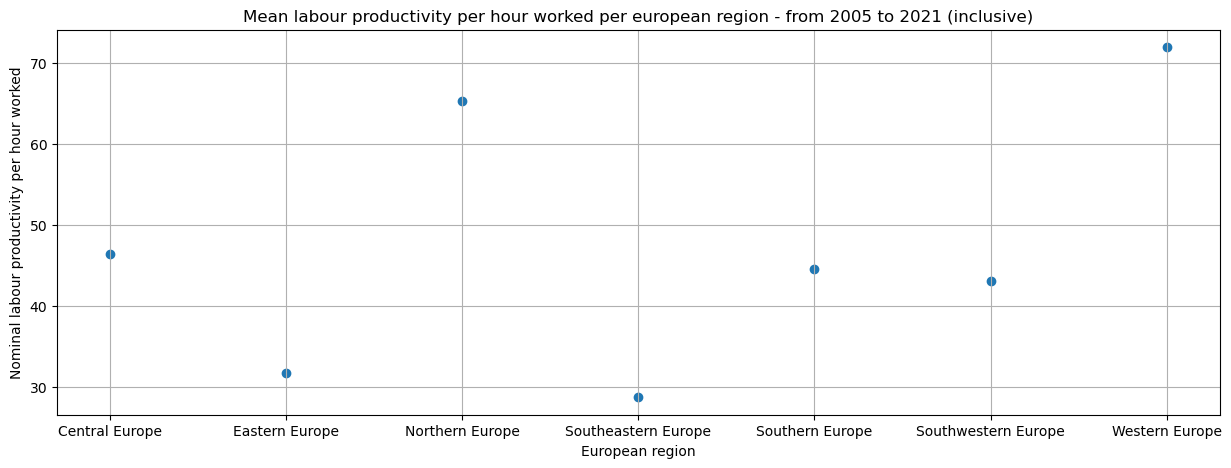

In [301]:
# plots the mean of every european region

plt.figure(figsize=(15, 5))

plt.scatter(['Central Europe', 'Eastern Europe', 'Northern Europe', 'Southeastern Europe', 'Southern Europe', 'Southwestern Europe', 'Western Europe'], europeMeans)

plt.grid()

plt.xlabel('European region') 
plt.ylabel('Nominal labour productivity per hour worked') 
plt.title("Mean labour productivity per hour worked per european region - from 2005 to 2021 (inclusive)")
plt.show()

In [304]:
NorthAmerica = [Mexico, UnitedStates, Canada, CostaRica]
SouthAmerica = [Chile, Colombia]
Africa = [SouthAfrica]
Oceania = [Australia, NewZealand]
Asia = [Japan, Korea, Russia, Israel]
restOfTheWorldMeans = [NorthAmericaMeans, SouthAmericaMeans, AfricaMeans, OceaniaMeans, AsiaMeans]
restOfTheWorldStrings = [['Mexico', 'UnitedStates', 'Canada', 'CostaRica'], ['Chile', 'Colombia'], ['SouthAfrica'], ['Australia', 'NewZealand'], ['Japan', 'Korea', 'Russia', 'Israel']]

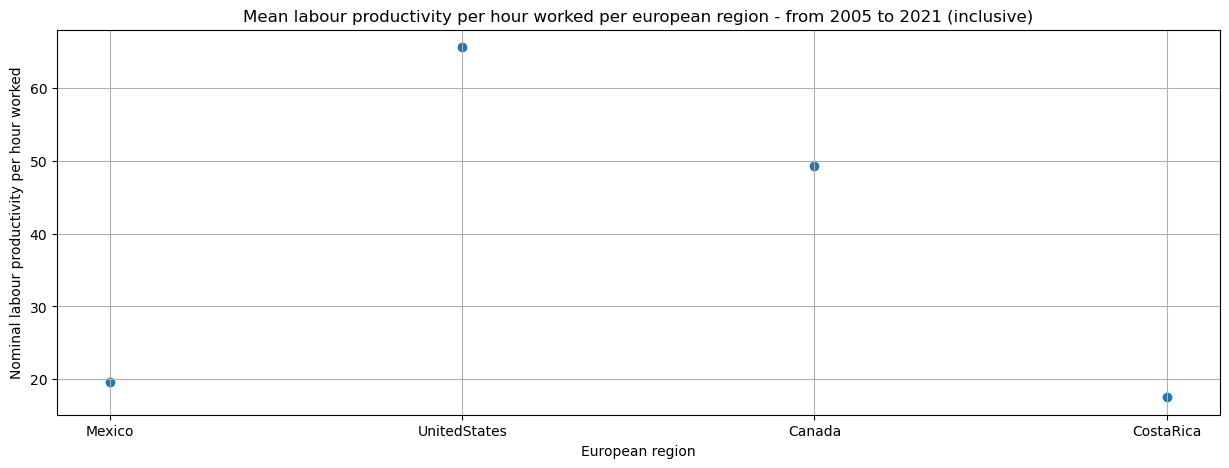

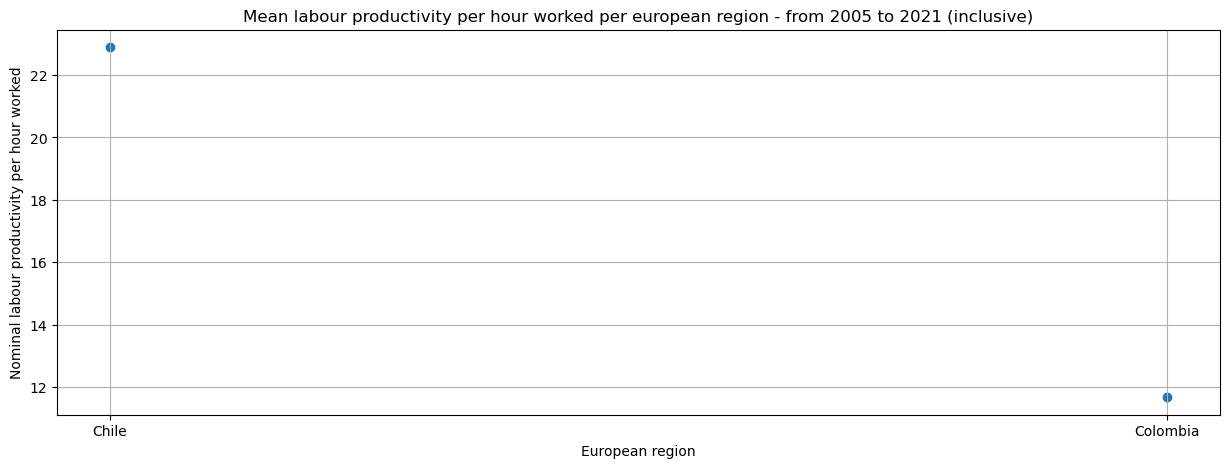

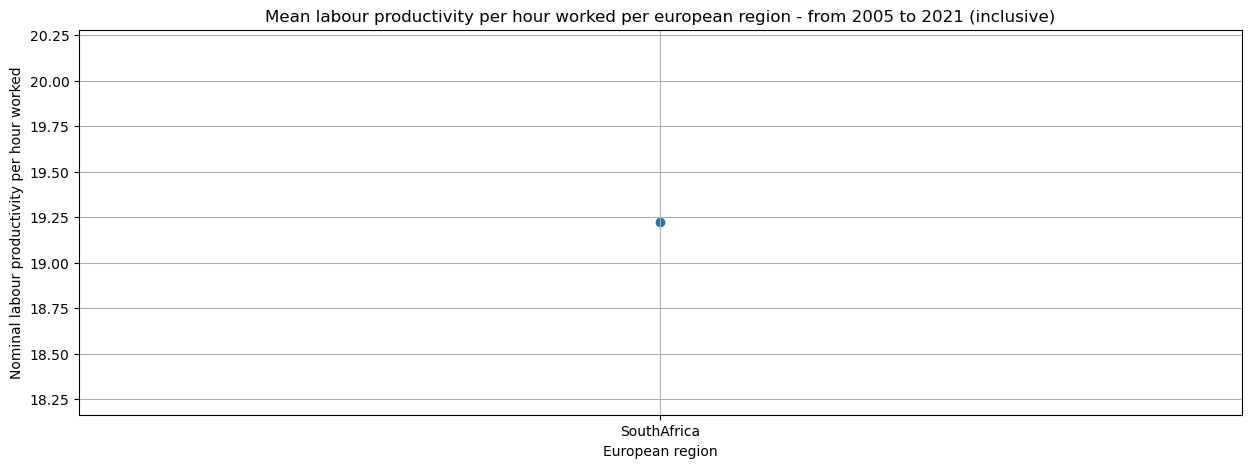

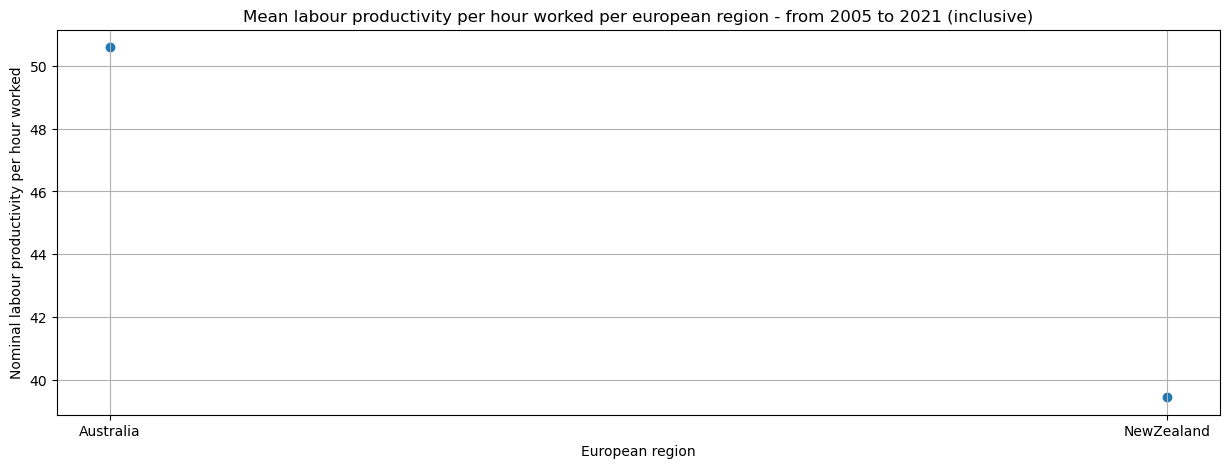

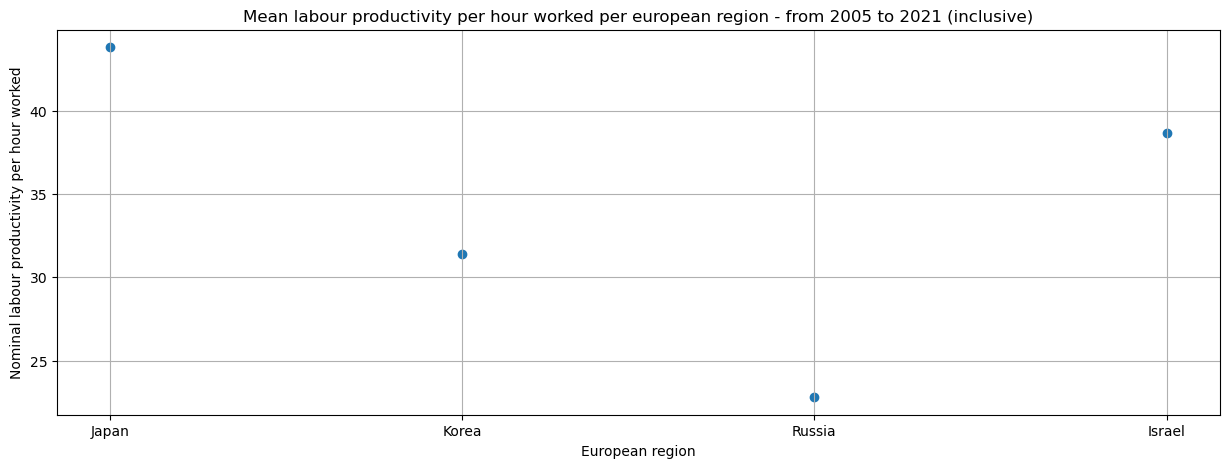

In [305]:
# plots the mean of every european region

for index, region in enumerate(restOfTheWorldStrings):
    plt.figure(figsize=(15, 5))

    plt.scatter(region, restOfTheWorldMeans[index])

    plt.grid()

    plt.xlabel('European region') 
    plt.ylabel('Nominal labour productivity per hour worked') 
    plt.title("Mean labour productivity per hour worked per european region - from 2005 to 2021 (inclusive)")
    plt.show()

In [310]:
print(numberOfColumns)
print(EuropeFlat)

23
['AUT', 'CZE', 'DEU', 'HUN', 'POL', 'SVK', 'SVN', 'CHE', 'EST', 'LVA', 'LTU', 'DNK', 'FIN', 'NOR', 'SWE', 'ISL', 'BGR', 'HRV', 'ROU', 'TUR', 'GRC', 'ITA', 'PRT', 'ESP', 'BEL', 'FRA', 'IRL', 'LUX', 'NLD', 'GBR']


In [ ]:

for index, region in enumerate(worldRegions[1:]):
    mean = 0
    count = 0

    for country in region:
        if country in countryCodesPHW:
            countryMean = float(cleanedData.loc[cleanedData['LOCATION'] == country]['mean'])
            restOfTheWorldMeans[index].append(countryMean)
            mean += countryMean
            count += 1

    mean = mean/count
    worldRegionMeans.append(mean)

/var/folders/jv/flhd9_611gvdf13cfv1w9t640000gn/T/ipykernel_3592/3037073575.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cleanedData.columns[column], mean, c=colorsRegions[index])


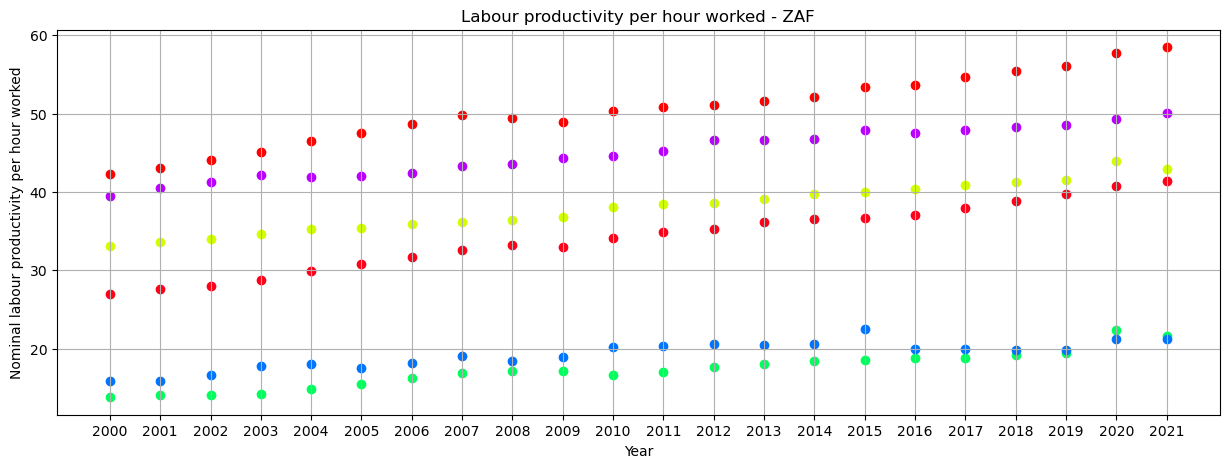

In [329]:
# plots each individual country throughout time

plt.figure(figsize=(15, 5))

colorsRegions = plt.cm.hsv(np.linspace(0, 1, len(worldRegions)))

for column in range(1, numberOfColumns):
    for index, region in enumerate(worldRegions):
        mean = 0
        count = 0
        for country in region:
            countryMean = float(cleanedData.loc[cleanedData['LOCATION'] == country][cleanedData.columns[column]])
            mean += countryMean
            count += 1

        mean = mean/count
        plt.scatter(cleanedData.columns[column], mean, c=colorsRegions[index])

plt.grid()
plt.xlabel('Year') 
plt.ylabel('Nominal labour productivity per hour worked') 
plt.title("Labour productivity per hour worked - " + countryCode)

plt.show()

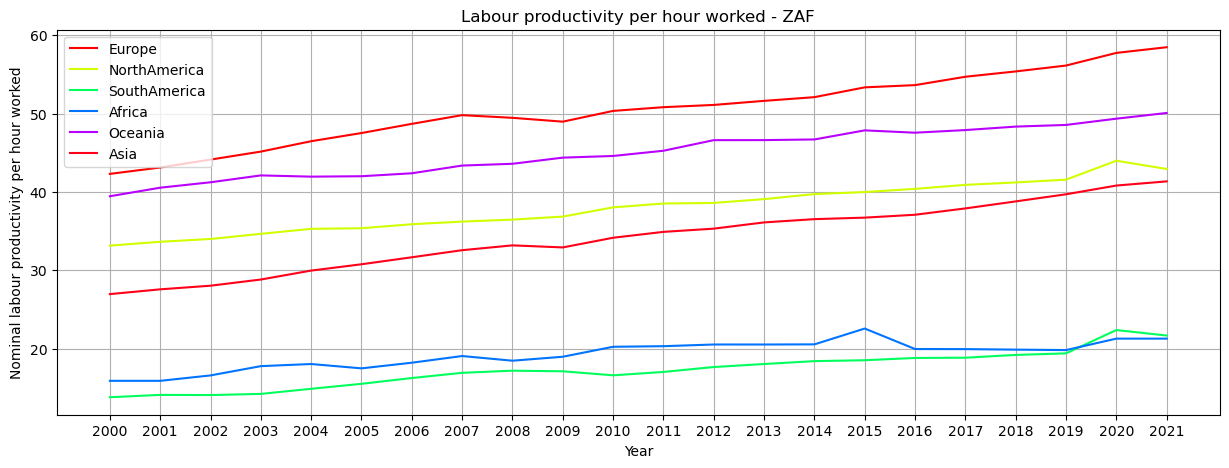

In [338]:
# plots each individual country throughout time

worldRegionsStrings = ['Europe', 'NorthAmerica', 'SouthAmerica', 'Africa', 'Oceania', 'Asia']

plt.figure(figsize=(15, 5))

colorsRegions = plt.cm.hsv(np.linspace(0, 1, len(worldRegions)))

worldRegionsTimeSeries = [np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1)]

for row in range(numberOfRows):
    country = cleanedData.iloc[row]['LOCATION']
    for index, region in enumerate(worldRegions):
        if country in region:
            worldRegionsTimeSeries[index] = np.add(worldRegionsTimeSeries[index], cleanedData.iloc[row][1:-1])

for index, region in enumerate(worldRegions):
    plt.plot(cleanedData.columns[1:-1], worldRegionsTimeSeries[index]/len(region), c=colorsRegions[index], label=worldRegionsStrings[index])

plt.grid()
plt.legend()
plt.xlabel('Year') 
plt.ylabel('Nominal labour productivity per hour worked') 
plt.title("Labour productivity per hour worked - " + countryCode)

plt.show()

Text(0.5, 1.0, 'Labour productivity per hour worked - ZAF')

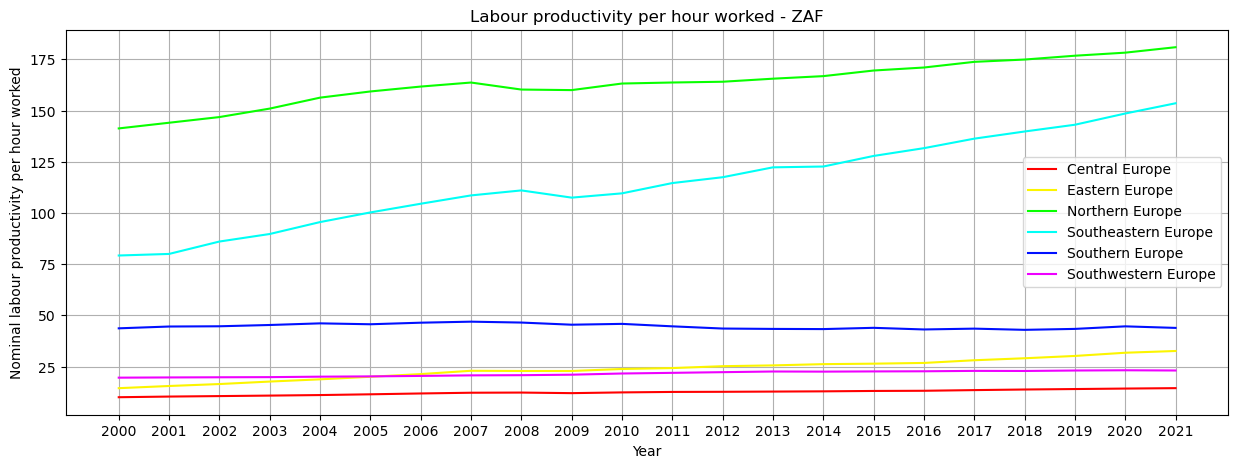

In [341]:
# plots each individual country throughout time

plt.figure(figsize=(15, 5))

europeRegionsStrings = ['Central Europe', 'Eastern Europe', 'Northern Europe', 'Southeastern Europe', 'Southern Europe', 'Southwestern Europe', 'Western Europe']

colorsRegions = plt.cm.hsv(np.linspace(0, 1, len(Europe)))

europeSubregionsTimeSeries = [np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1)]

for row in range(numberOfRows):
    country = cleanedData.iloc[row]['LOCATION']
    for index, region in enumerate(Europe):
        if country in region:
            europeSubregionsTimeSeries[index] = np.add(europeSubregionsTimeSeries[index], cleanedData.iloc[row][1:-1])

for index, region in enumerate(worldRegions):
    plt.plot(cleanedData.columns[1:-1], europeSubregionsTimeSeries[index]/len(region), c=colorsRegions[index], label=europeRegionsStrings[index])

plt.grid()
plt.legend()
plt.xlabel('Year') 
plt.ylabel('Nominal labour productivity per hour worked') 
plt.title("Labour productivity per hour worked - " + countryCode)

Text(0.5, 1.0, 'Labour productivity per hour worked - ZAF')

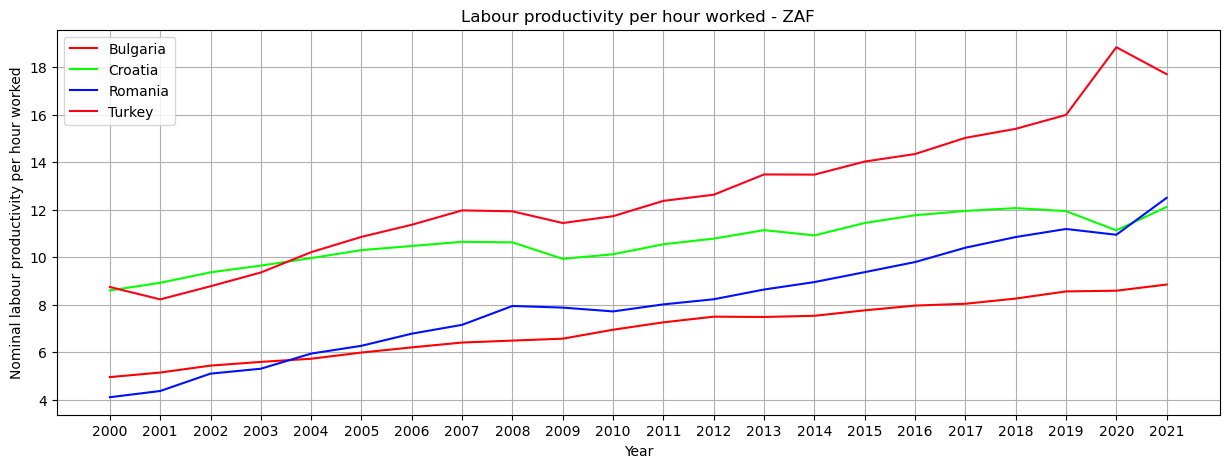

In [343]:
# plots each individual country throughout time

plt.figure(figsize=(15, 5))

SouthEasternEuropeStrings = ['Bulgaria', 'Croatia', 'Romania', 'Turkey']

colorsRegions = plt.cm.hsv(np.linspace(0, 1, len(SouthEasternEuropeStrings)))

europeSubregionsTimeSeries = [np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1), np.zeros(numberOfColumns-1)]

for row in range(numberOfRows):
    country = cleanedData.iloc[row]['LOCATION']
    for index, c in enumerate(SouthEasternEurope):
        if country == c:
            europeSubregionsTimeSeries[index] = np.add(europeSubregionsTimeSeries[index], cleanedData.iloc[row][1:-1])

for index, region in enumerate(SouthEasternEurope):
    plt.plot(cleanedData.columns[1:-1], europeSubregionsTimeSeries[index]/len(region), c=colorsRegions[index], label=SouthEasternEuropeStrings[index])

plt.grid()
plt.legend()
plt.xlabel('Year') 
plt.ylabel('Nominal labour productivity per hour worked') 
plt.title("Labour productivity per hour worked - " + countryCode)